In [1]:
import numpy as np
import pymc as pm
import pytensor
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr

OpenBLAS blas_thread_init: pthread_create failed for thread 33 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 512 current, 512 max
OpenBLAS blas_thread_init: pthread_create failed for thread 34 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 512 current, 512 max
OpenBLAS blas_thread_init: pthread_create failed for thread 35 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 512 current, 512 max
OpenBLAS blas_thread_init: pthread_create failed for thread 36 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 512 current, 512 max
OpenBLAS blas_thread_init: pthread_create failed for thread 37 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 512 current, 512 max
OpenBLAS blas_thread_init: pthread_create failed for thread 38 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 512 current, 512 max
OpenBLAS blas_th

KeyboardInterrupt: 

### Example from Online for Linear Regression with PyMC ###

Taken as a combination of https://www.geeksforgeeks.org/implementation-of-bayesian-regression/ and https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/projects/e21062/tg/venv/lib/python3.7/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


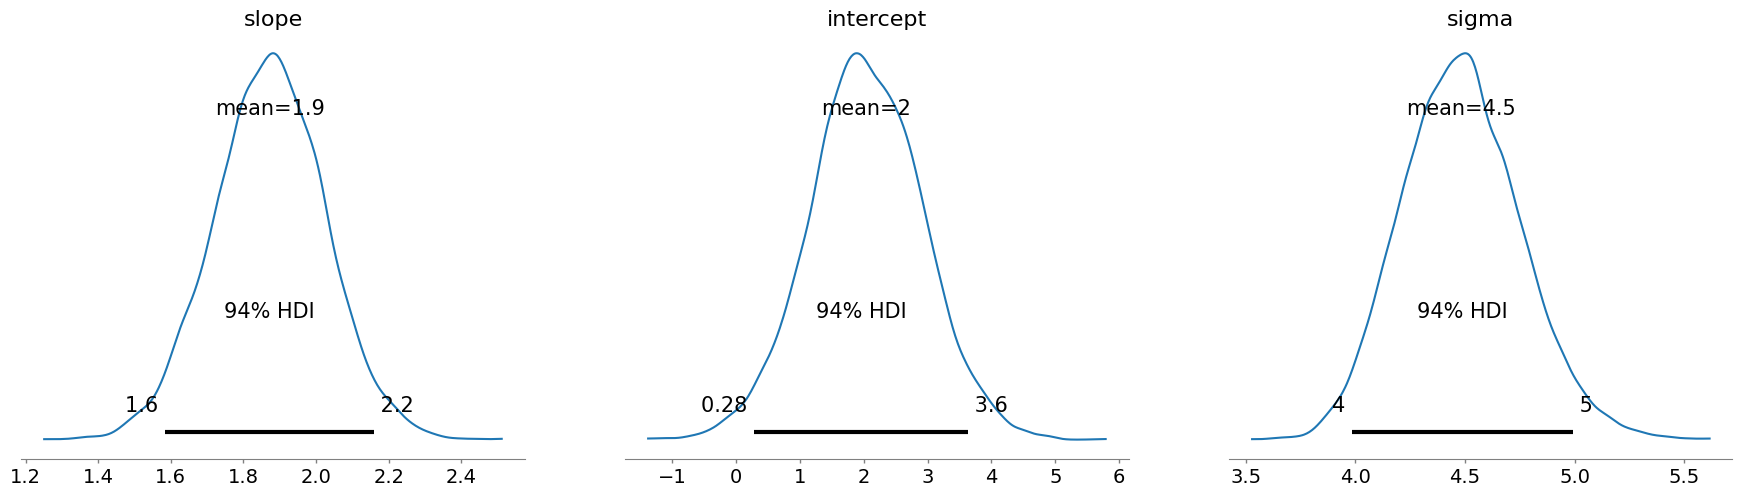

/projects/e21062/tg/venv/lib/python3.7/site-packages/arviz/plots/lmplot.py:209: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/projects/e21062/tg/venv/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


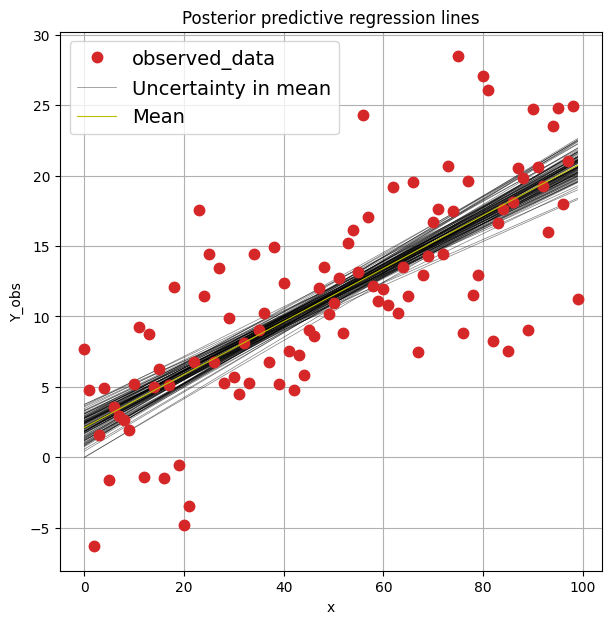

In [3]:
# Generate some sample data
np.random.seed(10)
X = np.linspace(0, 10, 100)
true_slope = 2
true_intercept = 1
Y = true_intercept + true_slope * X + np.random.normal(0, 5, size=100)
 
# Create a PyMC model
with pm.Model() as model:
    # Priors for the parameters
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
 
    # Expected value of the outcome
    mu = intercept + slope * X
 
    # Likelihood (sampling distribution) of the observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
 
    # Run the MCMC sampling
    trace = pm.sample(3000, tune=1000)
 
# Plot the posterior distributions
pm.plot_posterior(trace, var_names=['slope', 'intercept', 'sigma'])
plt.show()

#az.plot_trace(trace, figsize=(10, 7));
trace.posterior["y_model"] = trace.posterior["intercept"] + trace.posterior["slope"] * xr.DataArray(X)

_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace, y="Y_obs", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");


### Beta-Decay Attempt ###

Setup the Bateman equations first generically...

In [4]:
import pandas as pd

def parent(t_parent, a0, x):
    return a0*(np.exp(-((np.log(2))/t_parent)*x));
    
def daughter0n(t_daugh0n, t_parent, a0, branch0n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh0n):
        return a0*(branch0n)*(((np.log(2))/t_daugh0n)/(((np.log(2))/t_daugh0n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh0n)*x)))
    else:
        return a0*(branch0n)*(((np.log(2))/t_daugh0n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh0n)*x)))

def daughter1n(t_daugh1n, t_parent, a0, branch1n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh1n):
        return a0*(branch1n)*(((np.log(2))/t_daugh1n)/(((np.log(2))/t_daugh1n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh1n)*x)))
    else:
        return a0*(branch1n)*(((np.log(2))/t_daugh1n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh1n)*x)))

def daughter2n(t_daugh2n, t_parent, a0, branch2n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh2n):
        return a0*(branch2n)*(((np.log(2))/t_daugh2n)/(((np.log(2))/t_daugh2n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh2n)*x)))
    else:
        return a0*(branch2n)*(((np.log(2))/t_daugh2n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh2n)*x)))

def daughter3n(t_daugh3n, t_parent, a0, branch3n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh3n):
        return a0*(branch3n)*(((np.log(2))/t_daugh3n)/(((np.log(2))/t_daugh3n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh3n)*x)))
    else:
        return a0*(branch3n)*(((np.log(2))/t_daugh3n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh3n)*x)))

def background(bkg, x):
    return bkg

def parentDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + background(bkg, x)

def parent1nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + background(bkg, x)

def parent2nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, branch0n, branch1n, branch2n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + background(bkg, x)

def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n, branch0n, branch1n, branch2n, branch3n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + daughter3n(t_daugh3n, t_parent, a0, branch3n, x) + background(bkg, x)


Setting up for an arbitrary example just to test the analysis etc.

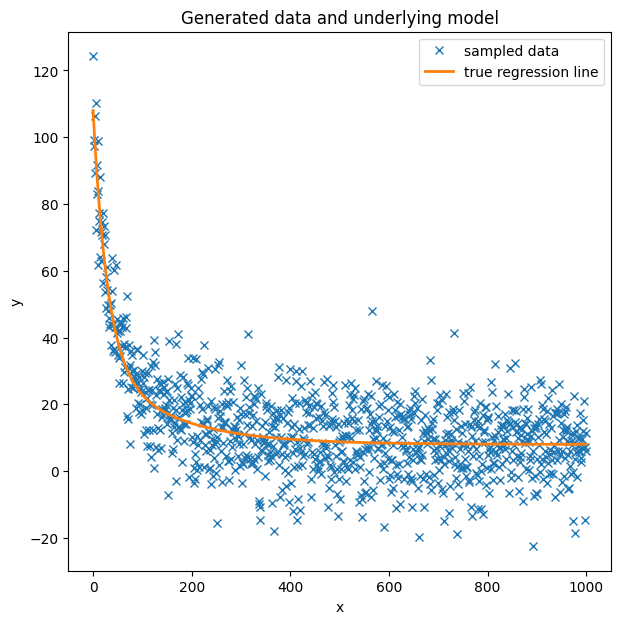

In [5]:
# Generate some sample data
np.random.seed(1)
x = np.linspace(0, 1000, 1000)
parentHalf = 20
daughter0nHalf = 100
a0 = 100
branch0n = 1
backgroundLevel = 8
y = parent1nDaughterLinear(a0, parentHalf, daughter0nHalf, 1000, branch0n, 0., backgroundLevel, x) + np.random.normal(0, 10, size=1000)
trueFit = parent1nDaughterLinear(a0, parentHalf, daughter0nHalf, 1000, branch0n, 0., backgroundLevel, x)

data = pd.DataFrame(dict(x=x, y=y))
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, trueFit, label="true regression line", lw=2.0)
plt.legend(loc=0);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, initialActivity, branch0n, branch1n, backgroundLevel, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 39 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7097, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


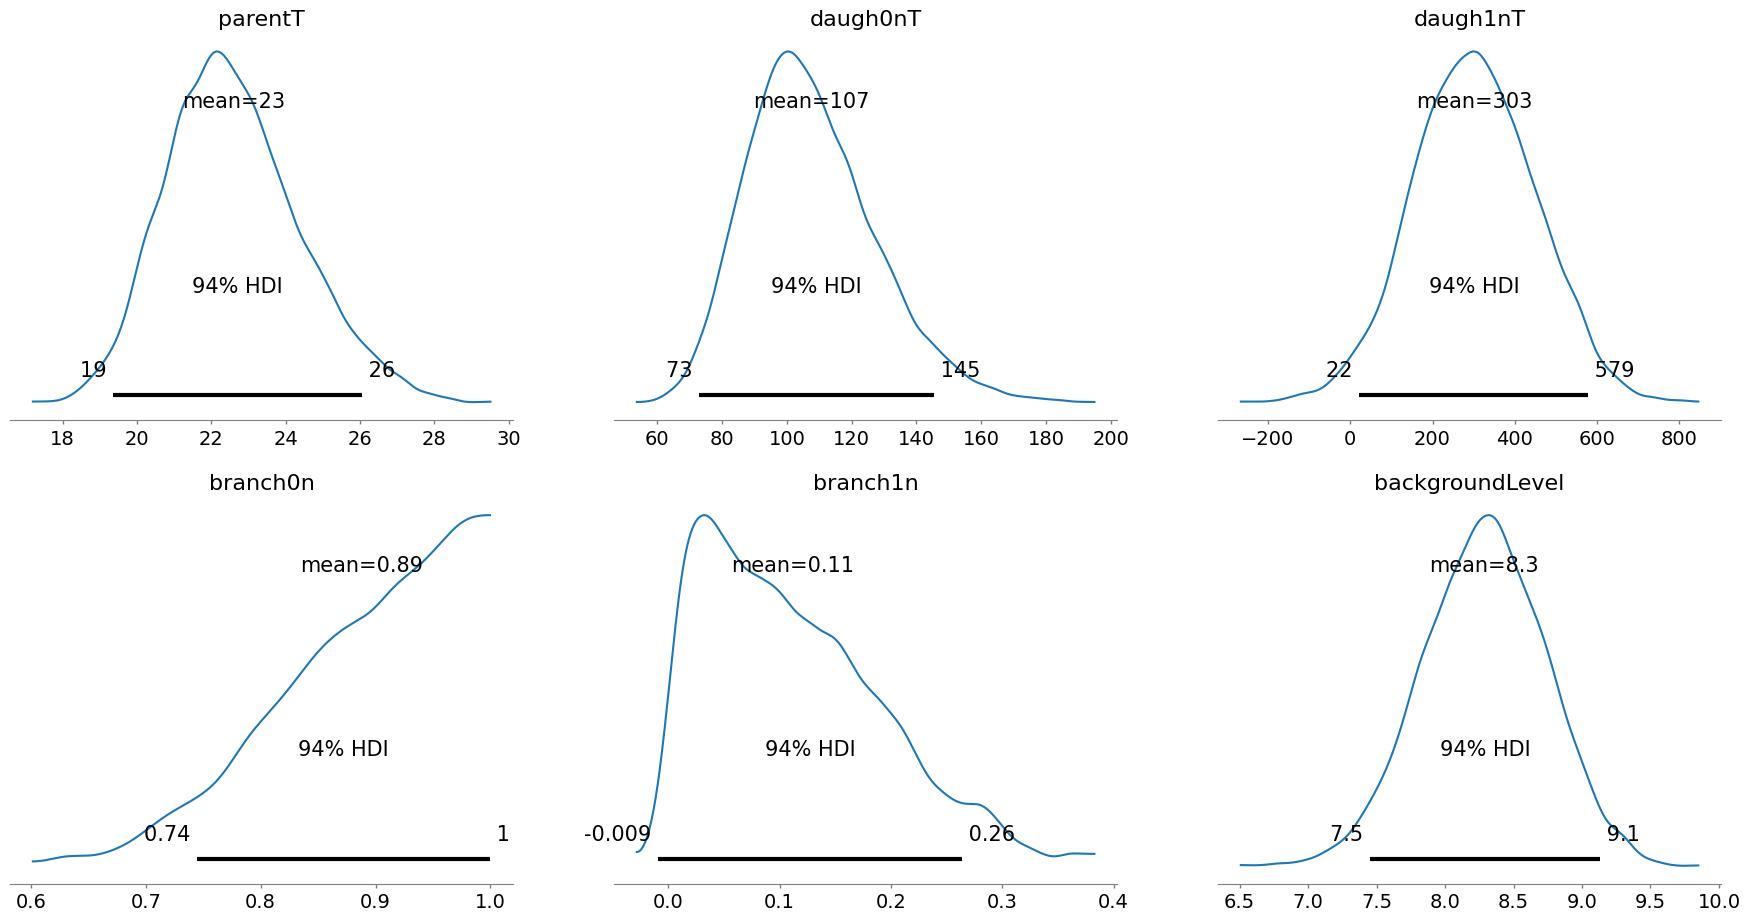

In [6]:
# Create a PyMC model
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=30, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=80, sigma=40)
    daughter1nThalf = pm.Normal('daugh1nT', mu=300, sigma=150)
    initialActivity = pm.Normal('initialActivity', mu=100, sigma=30)
    branch0n = pm.Uniform('branch0n', 0., 1.)
    #branch1n = pm.Uniform('branch1n', 0, (1.-branch0n))
    branch1n = pm.Normal('branch1n', mu=(1.-branch0n), sigma=0.01)
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of the outcome
    mu = parentDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, branch0n, branch1n, backgroundLevel, x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
 
    # Run the MCMC sampling
    trace = pm.sample(3000, tune=1000)
 
# Plot the posterior distributions
pm.plot_posterior(trace, var_names=['parentT', 'daugh0nT', 'daugh1nT', 'branch0n', 'branch1n', 'backgroundLevel'])
plt.show()


array([[<AxesSubplot:ylabel='daugh0nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='initialActivity'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='branch1n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='parentT', ylabel='branch0n'>,
        <AxesSubplot:xlabel='daugh0nT'>,
        <AxesSubplot:xlabel='initialActivity'>,
        <AxesSubplot:xlabel='branch1n'>]], dtype=object)

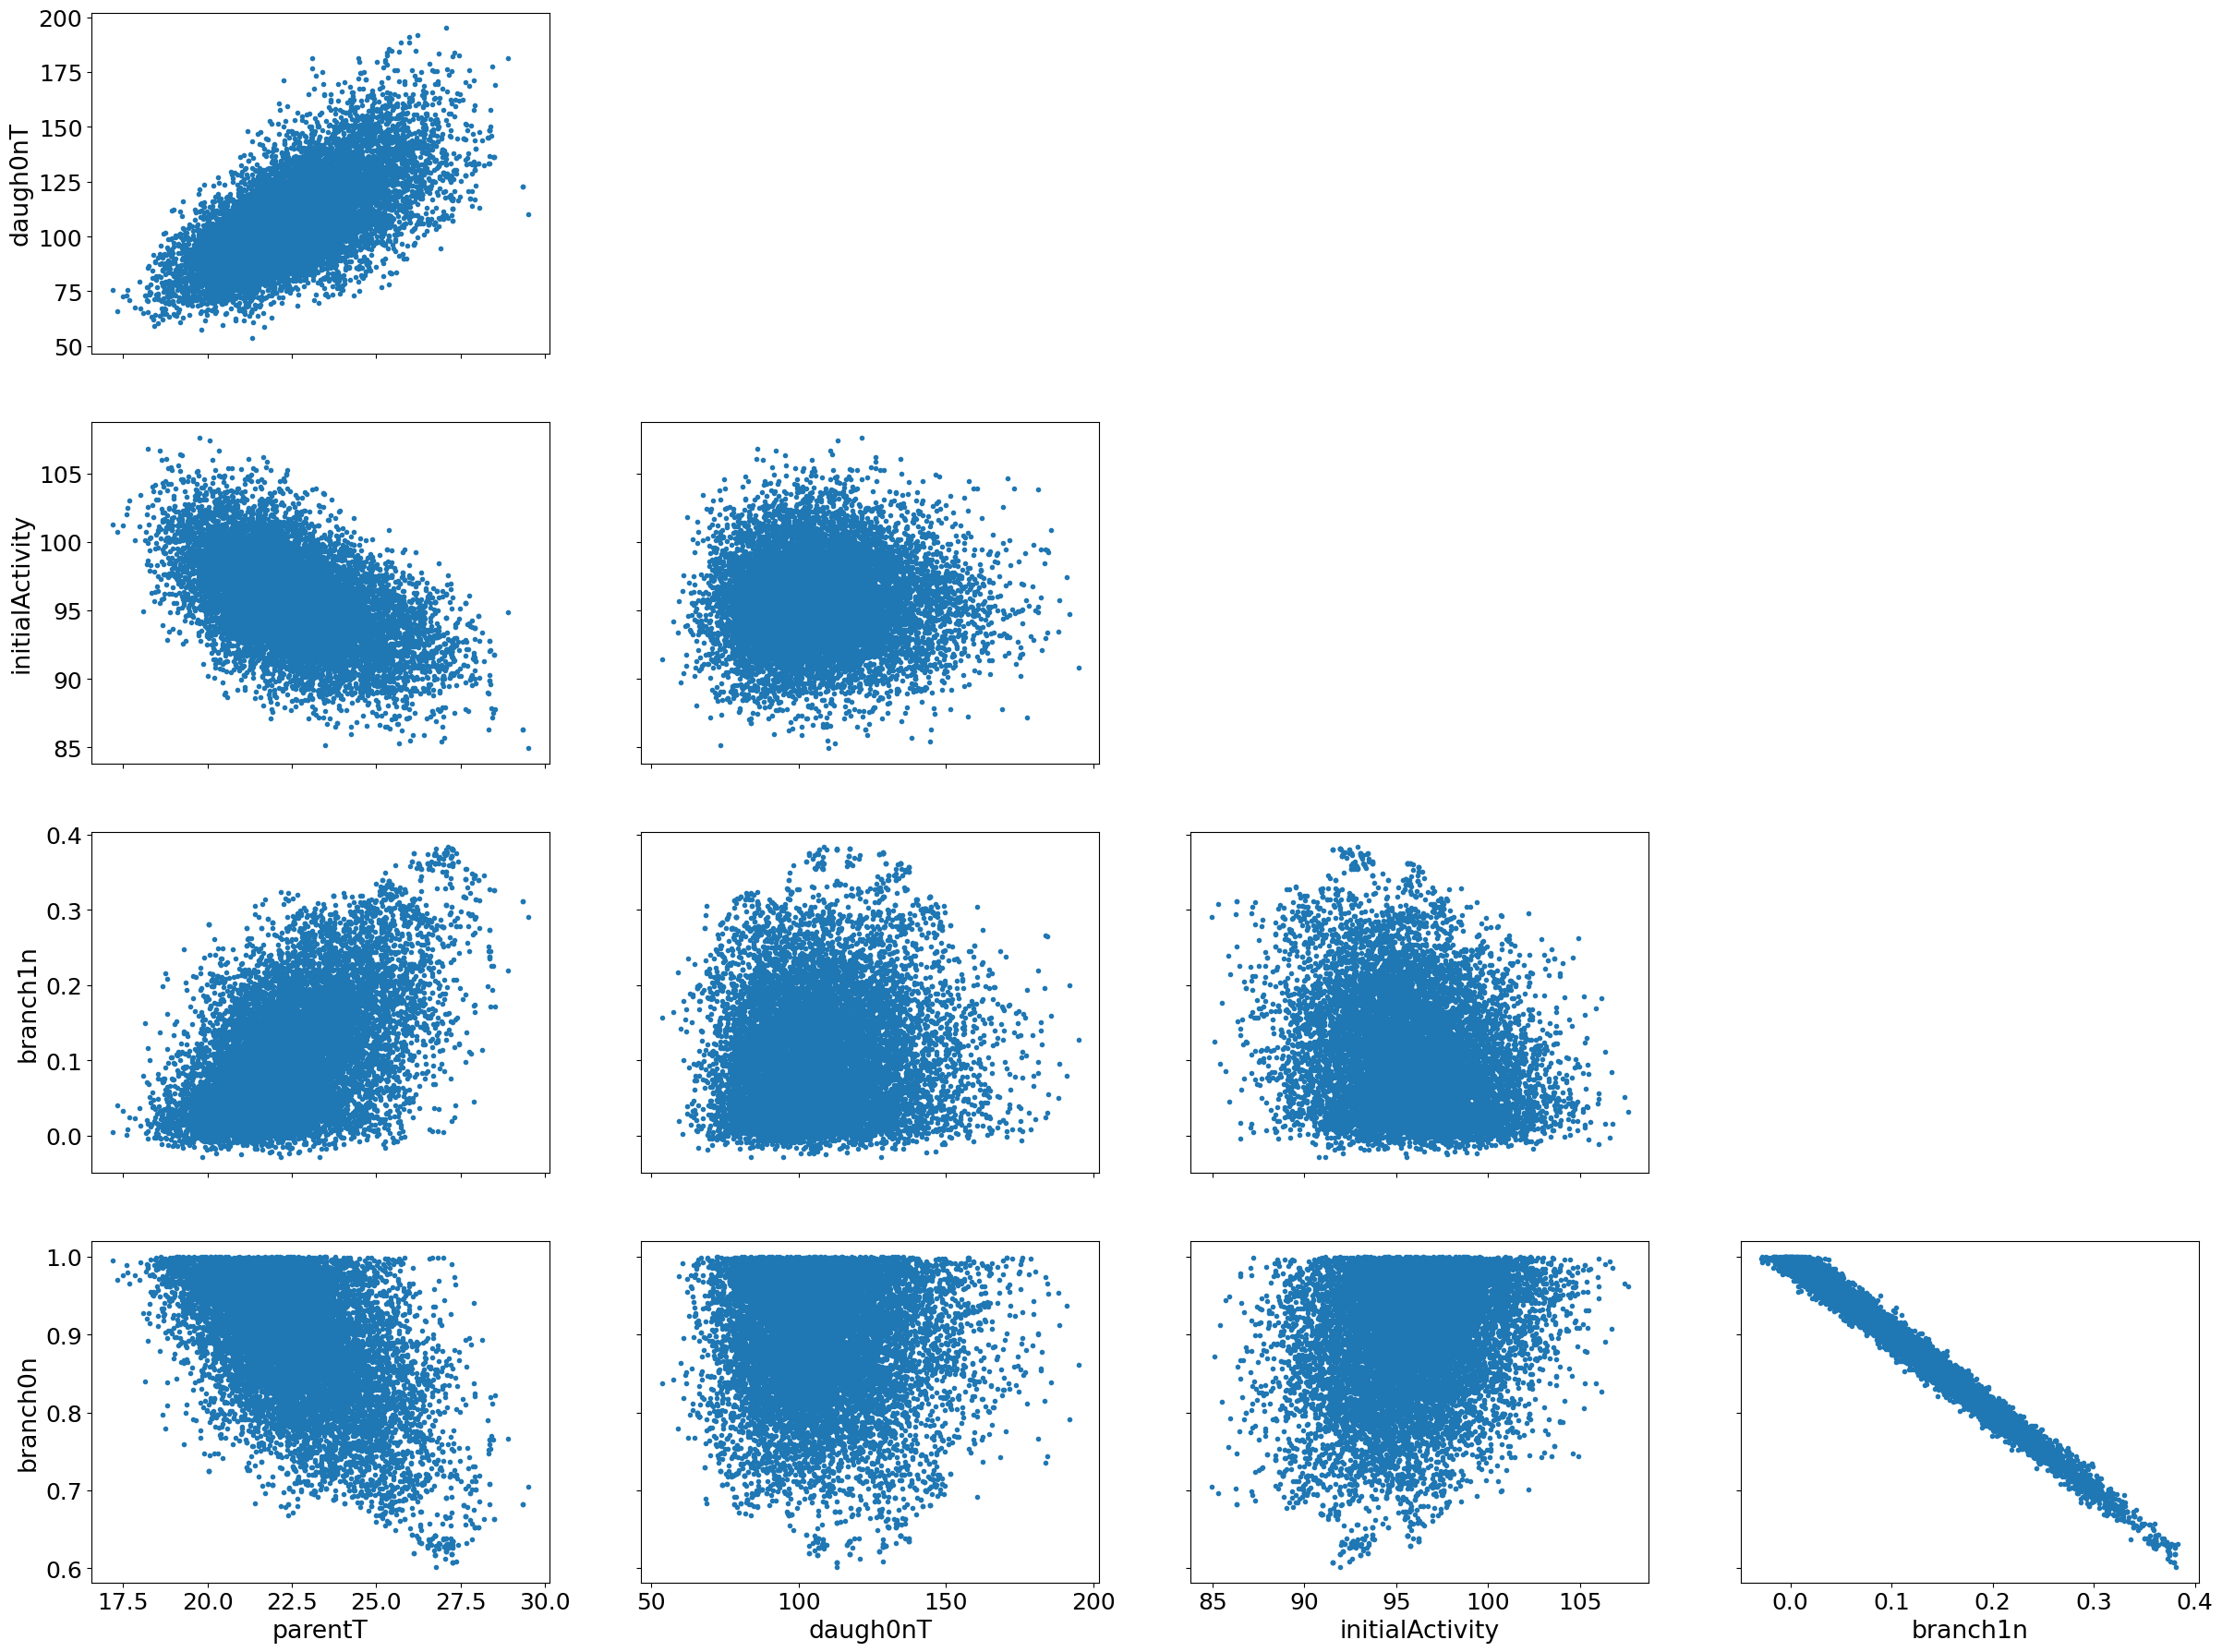

In [7]:
az.plot_pair(trace, var_names=['initialActivity', 'daugh0nT', 'parentT', 'branch0n', 'branch1n'],
            filter_vars="regex",
            divergences=False,
            textsize=18)

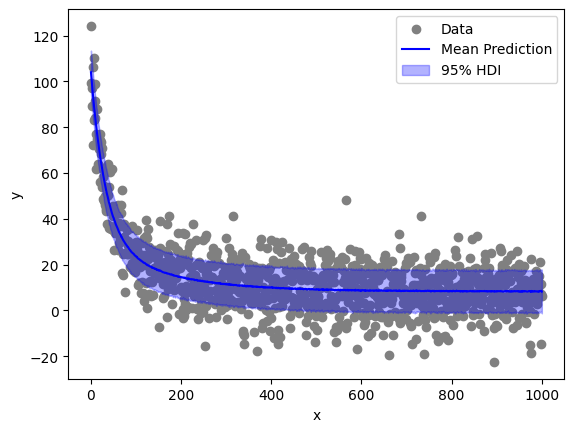

In [8]:
ppc = pm.sample_posterior_predictive(trace, model=model).posterior_predictive
y_pred = np.mean(ppc['y_obs'], axis=0)

y_mean = np.mean(y_pred, axis=0)

y_hdi_lower, y_hdi_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)

# Plot the data points
plt.scatter(x, y, color='grey', label='Data')

# Plot the mean prediction
plt.plot(x, y_mean, color='blue', label='Mean Prediction')

# Plot the HDI intervals as error bars
plt.fill_between(x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 31F Fitting ###
Real analysis for the case of 31F first.

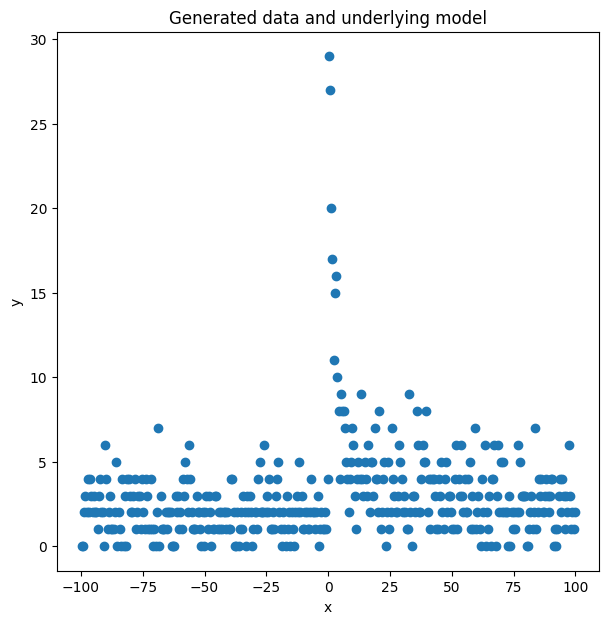

In [9]:
df31F = pd.read_csv('hist_31F.csv')

x = df31F["xVal"]
y = df31F["yVal"]

fig31F = plt.figure(figsize=(7, 7))
ax2 = fig31F.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax2.plot(x, y, "o", label="Data")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [bkg_amp, bkg_lambda, sigma_bkg]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, nBranch, bkg_amp, bkg_lambda, sigma]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 34 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


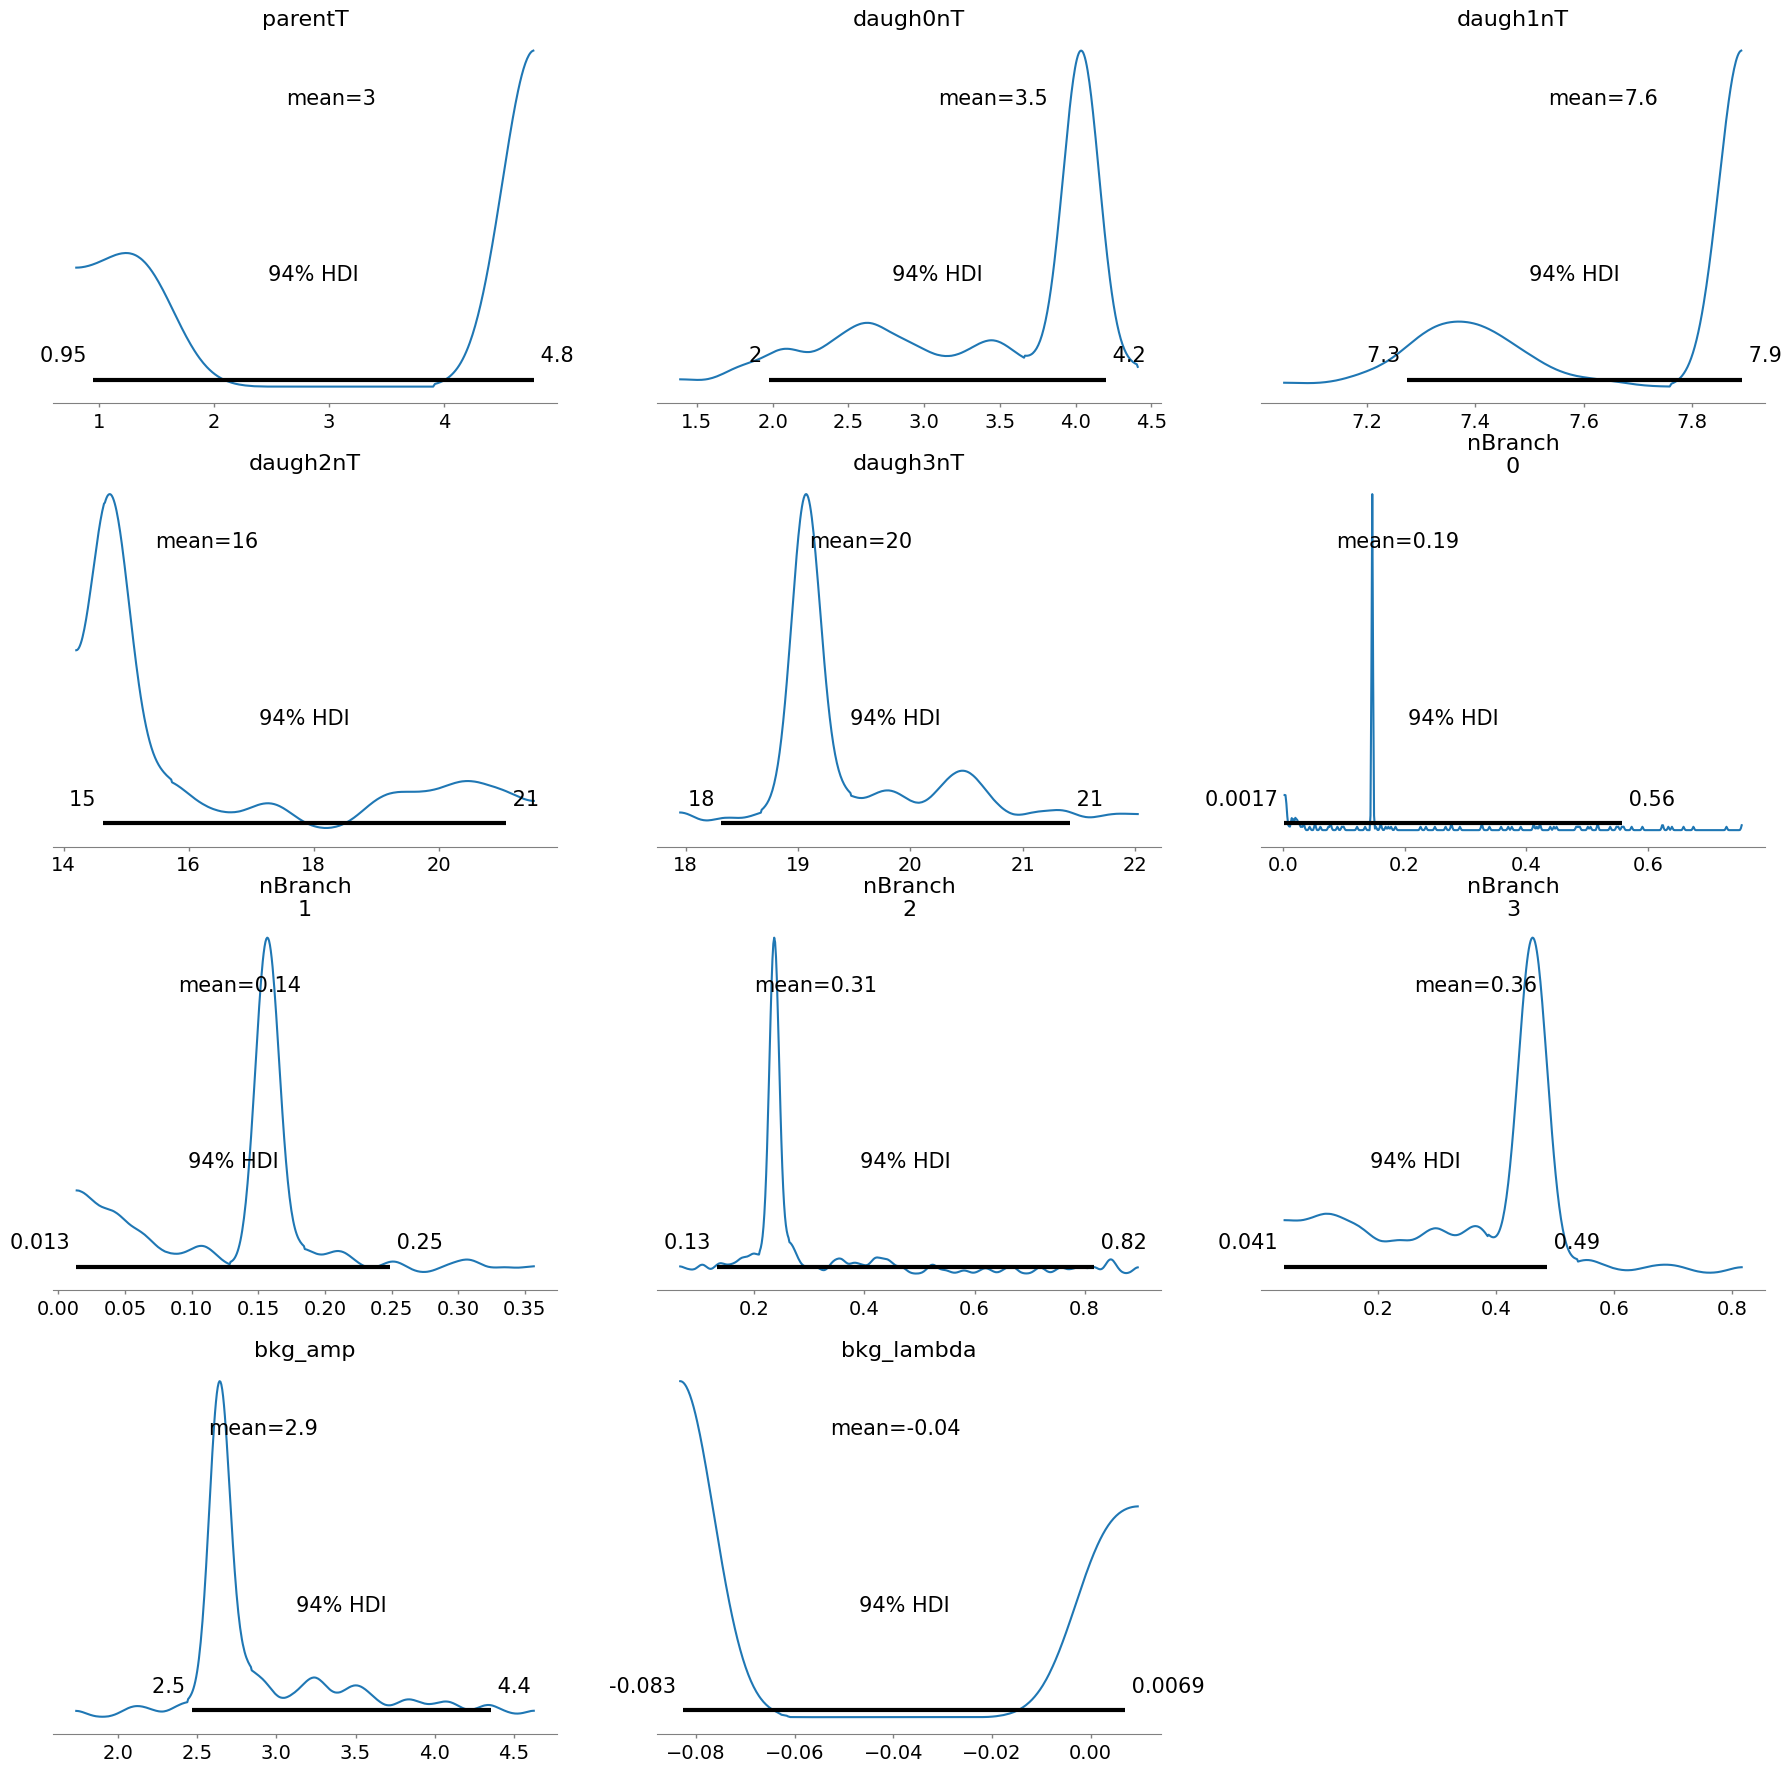

In [ ]:



# Split data
pre_x = x[x < 0]
pre_y = y[x < 0]
decay_x = x[x >= 0]
decay_y = y[x >= 0]

# --- Step 1: Fit background model on pre-decay region ---
with pm.Model() as bkg_model:
    bkg_amp = pm.HalfNormal('bkg_amp', sigma=50)
    bkg_lambda = pm.HalfNormal('bkg_lambda', sigma=0.1)

    bkg_mu = bkg_amp * pm.math.exp(bkg_lambda * pre_x)

    sigma_bkg = pm.HalfNormal('sigma_bkg', sigma=5)
    y_bkg_obs = pm.Normal('y_bkg_obs', mu=bkg_mu, sigma=sigma_bkg, observed=pre_y)

    trace_bkg = pm.sample(2000, tune=1000, target_accept=0.95, chains=2)

# Extract background fit means
bkg_amp_mean = np.mean(trace_bkg.posterior['bkg_amp'].stack(draws=("chain", "draw")).values)
bkg_lambda_mean = np.mean(trace_bkg.posterior['bkg_lambda'].stack(draws=("chain", "draw")).values)

# --- Step 2: Define decay model + exponential background ---

# Define the total decay function (no background inside!)
def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n,
                           branch0n, branch1n, branch2n, branch3n, x):
    return (
        parent(t_parent, a0, x)
        + daughter0n(t_daugh0n, t_parent, a0, branch0n, x)
        + daughter1n(t_daugh1n, t_parent, a0, branch1n, x)
        + daughter2n(t_daugh2n, t_parent, a0, branch2n, x)
        + daughter3n(t_daugh3n, t_parent, a0, branch3n, x)
    )

with pm.Model() as model:
    # Priors for decay and activity
    parentThalf = pm.Normal('parentT', mu=5, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=3.4, sigma=0.8)
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.39, sigma=0.11)
    daughter2nThalf = pm.Normal('daugh2nT', mu=15, sigma=3)
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma=1)
    initialActivity = pm.Normal('initialActivity', mu=30, sigma=20)

    # Branching ratios
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    #nBranch = pm.Dirichlet('nBranch', a=np.array([1e-6, 51, 24, 25]))
    nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])

    # Background with priors from previous fit
    bkg_amp = pm.Normal('bkg_amp', mu=bkg_amp_mean, sigma=10)
    bkg_lambda = pm.Normal('bkg_lambda', mu=bkg_lambda_mean, sigma=0.05)
    background = pm.Deterministic('background', bkg_amp * pm.math.exp(-bkg_lambda * decay_x))

    # Decay model
    decay_mu = parent3nDaughterLinear(
        initialActivity,
        parentThalf,
        daughter0nThalf,
        daughter1nThalf,
        daughter2nThalf,
        daughter3nThalf,
        nBranch[0], nBranch[1], nBranch[2], nBranch[3],
        decay_x
    )

    # Total model
    mu = pm.Deterministic('mu', decay_mu + background)

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Likelihood
    y_obs31F = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y)

    # Sampling
    trace31F = pm.sample(3000, tune=1000, target_accept=0.98, chains=2)

# --- Step 3: Posterior plots ---
pm.plot_posterior(trace31F, var_names=[
    'parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT',
    'nBranch', 'bkg_amp', 'bkg_lambda'
])
plt.show()


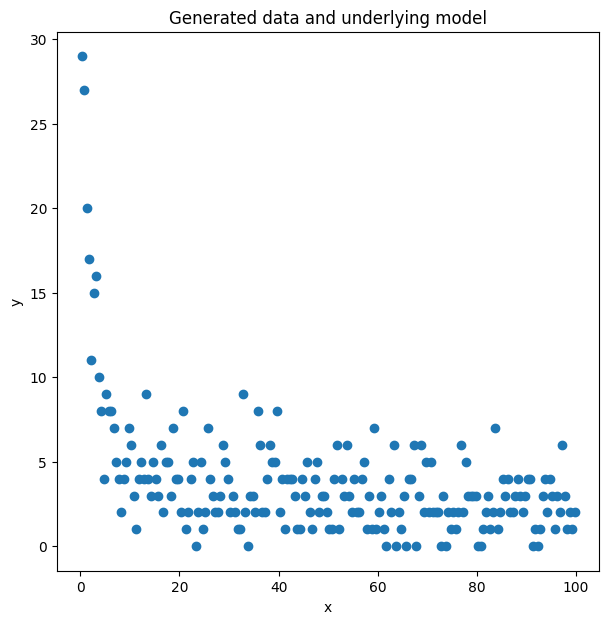

In [84]:
df31F = pd.read_csv('hist_31F.csv')

# Filter to only include 0 <= x <= 100
df31F = df31F[(df31F["xVal"] >= 0) & (df31F["xVal"] <= 100)]

x = df31F["xVal"]
y = df31F["yVal"]

fig31F = plt.figure(figsize=(7, 7))
ax2 = fig31F.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax2.plot(x, y, "o", label="Data")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, nBranch, backgroundLevel, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


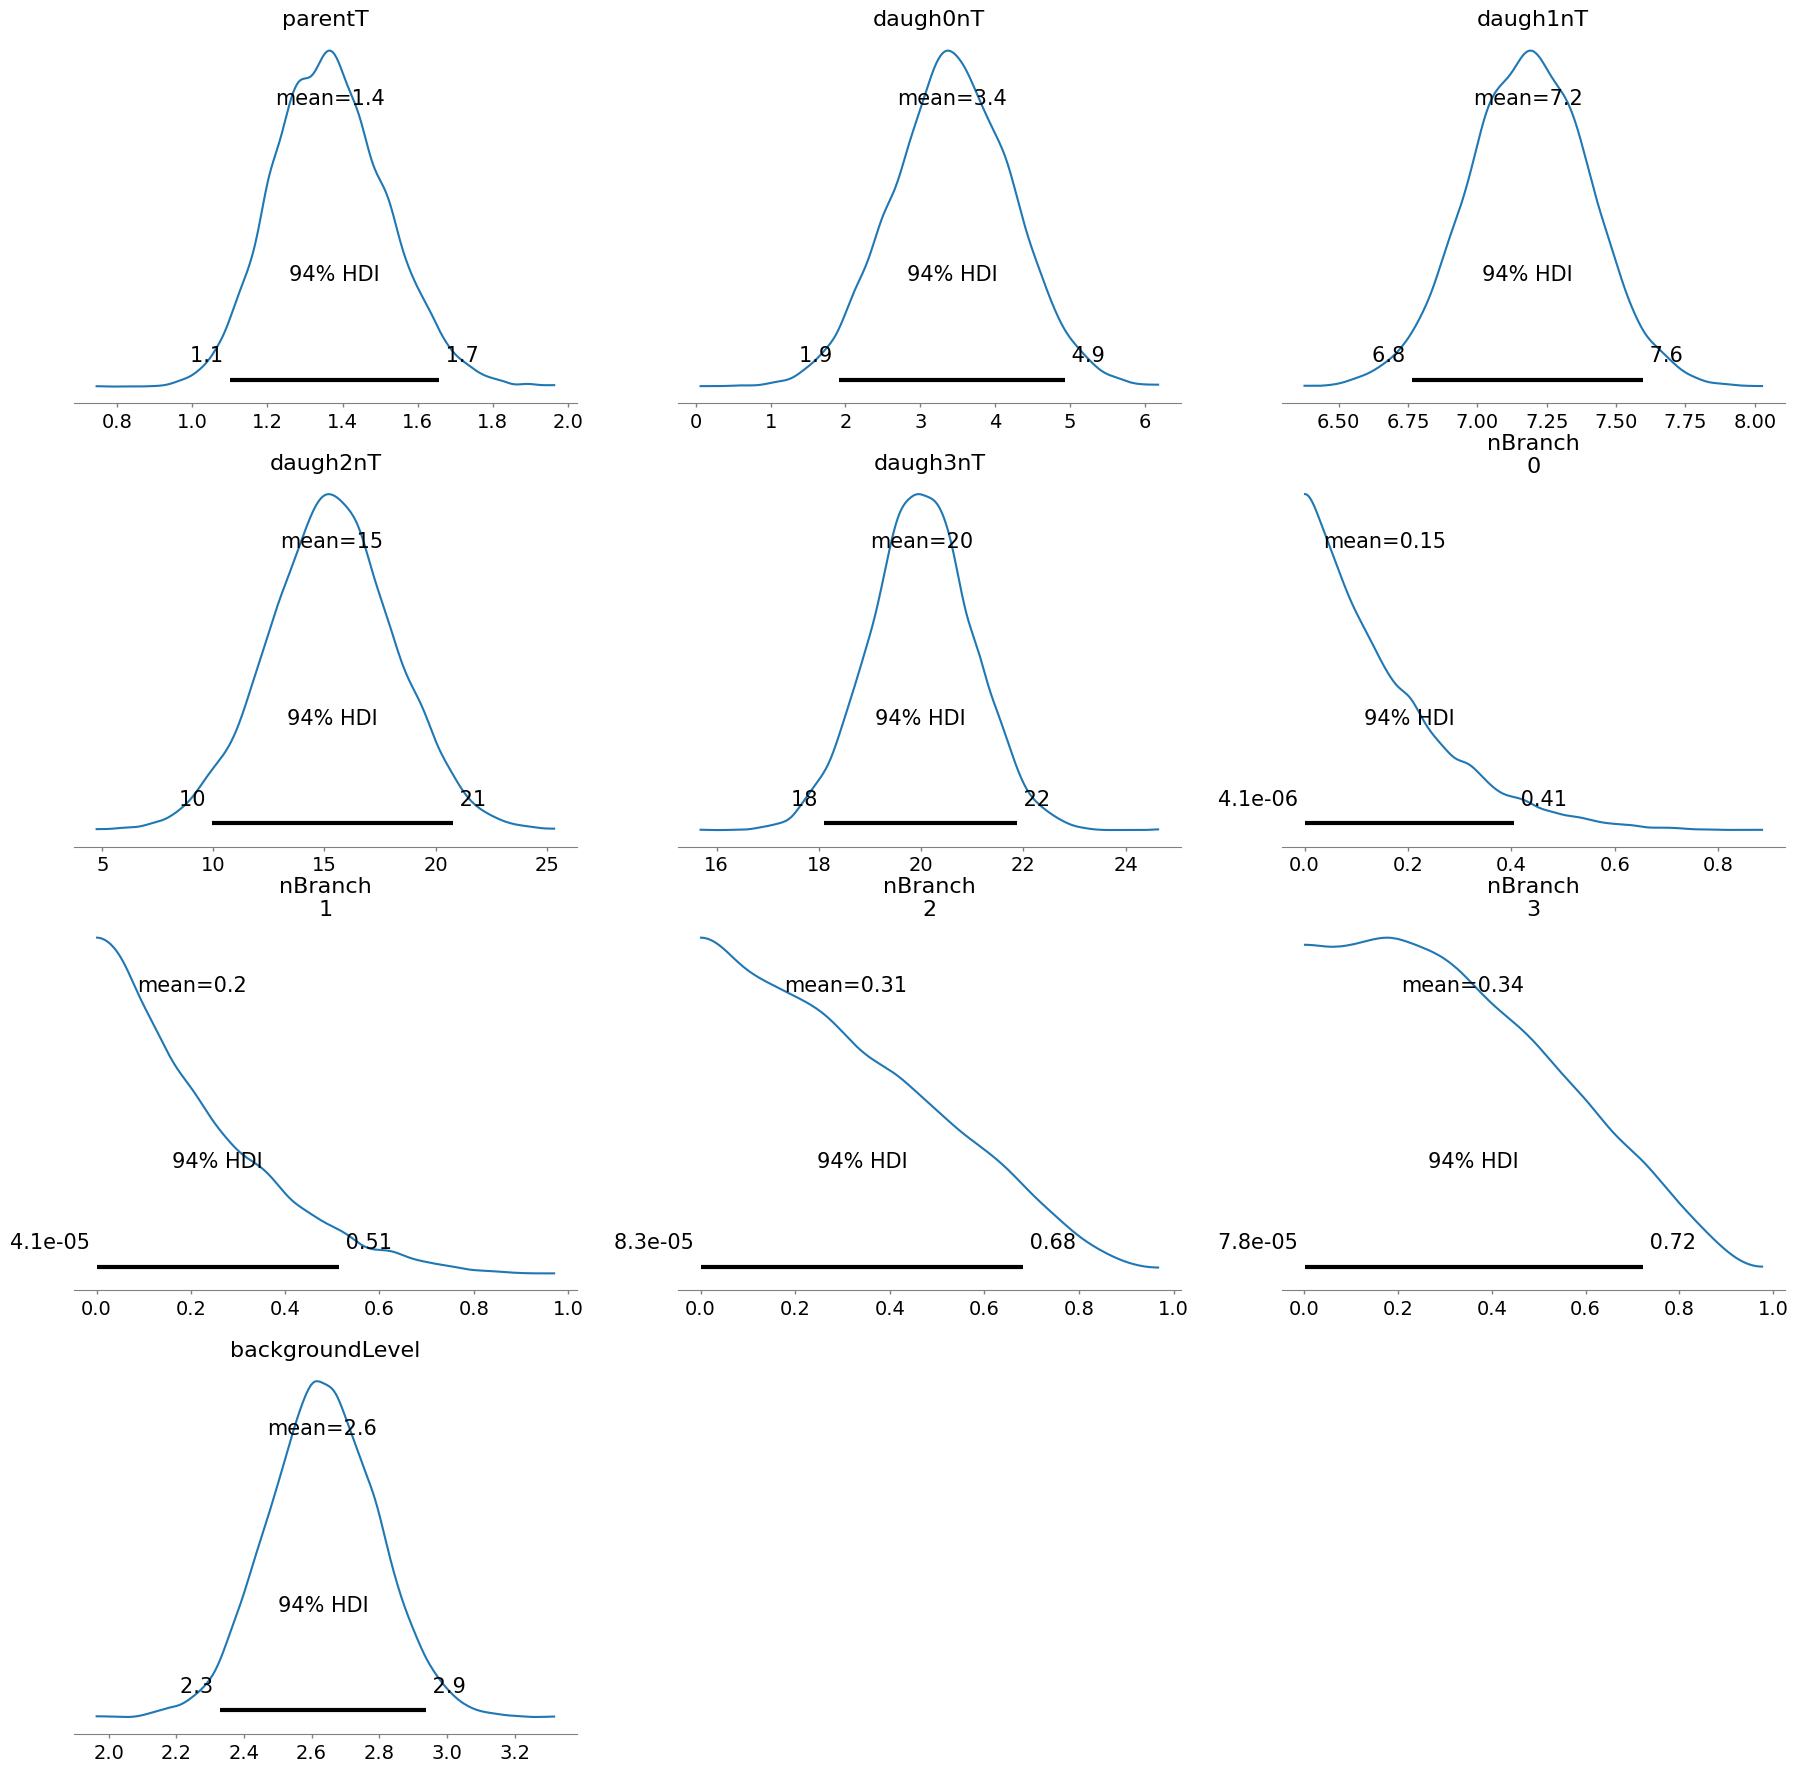

In [ ]:
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=5, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=3.4, sigma=0.8) # 31Ne T1/2 = 3.4(8)ms
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.18, sigma=0.22) # 30Ne T1/2 = 7.18(22)ms
    daughter2nThalf = pm.Normal('daugh2nT', mu=15, sigma = 3) # 29Ne T1/2 = 15(3) ms
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma = 1) # 28Ne T1/2 = 20(1) ms
    initialActivity = pm.Normal('initialActivity', mu=30, sigma=20)
    #branch0n = pm.Uniform('branch0n', 0., 0.1)
    #branch1n = pm.Uniform('branch1n', 0., (1.-branch0n))
    #branch2n = pm.Uniform('branch2n', 0., (1.-branch0n-branch1n))
    #branch3n = pm.Normal('branch3n', mu=(1.-branch0n-branch1n-branch2n), sigma=0.01)
    # nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])
    
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Expected value of the outcome
    mu = parent3nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, daughter3nThalf, nBranch[0], nBranch[1], nBranch[2], nBranch[3], backgroundLevel, x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs31F = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
 
    # Run the MCMC sampling
    #model.debug()
    trace31F = pm.sample(3000, tune=1000)

# Plot the posterior distributions

pm.plot_posterior(trace31F, var_names=['parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT', 'nBranch', 'backgroundLevel'])
plt.show()

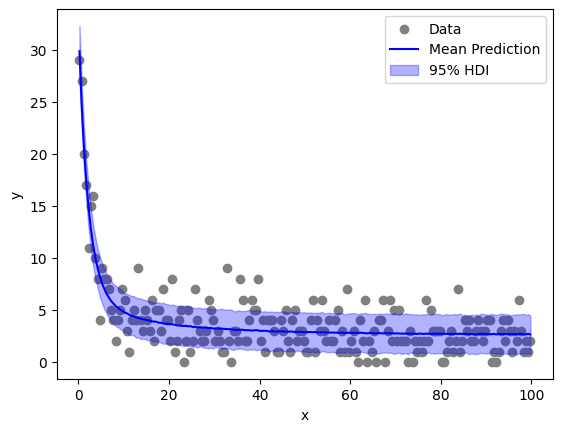

In [86]:
ppc = pm.sample_posterior_predictive(trace31F, model=model).posterior_predictive
y_pred = np.mean(ppc['y_obs'], axis=0)

y_mean = np.mean(y_pred, axis=0)

y_hdi_lower, y_hdi_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)

# Plot the data points
plt.scatter(x, y, color='grey', label='Data')

# Plot the mean prediction
plt.plot(x, y_mean, color='blue', label='Mean Prediction')

# Plot the HDI intervals as error bars
plt.fill_between(x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

array([[<AxesSubplot:ylabel='daugh0nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh1nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh2nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh3nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubp

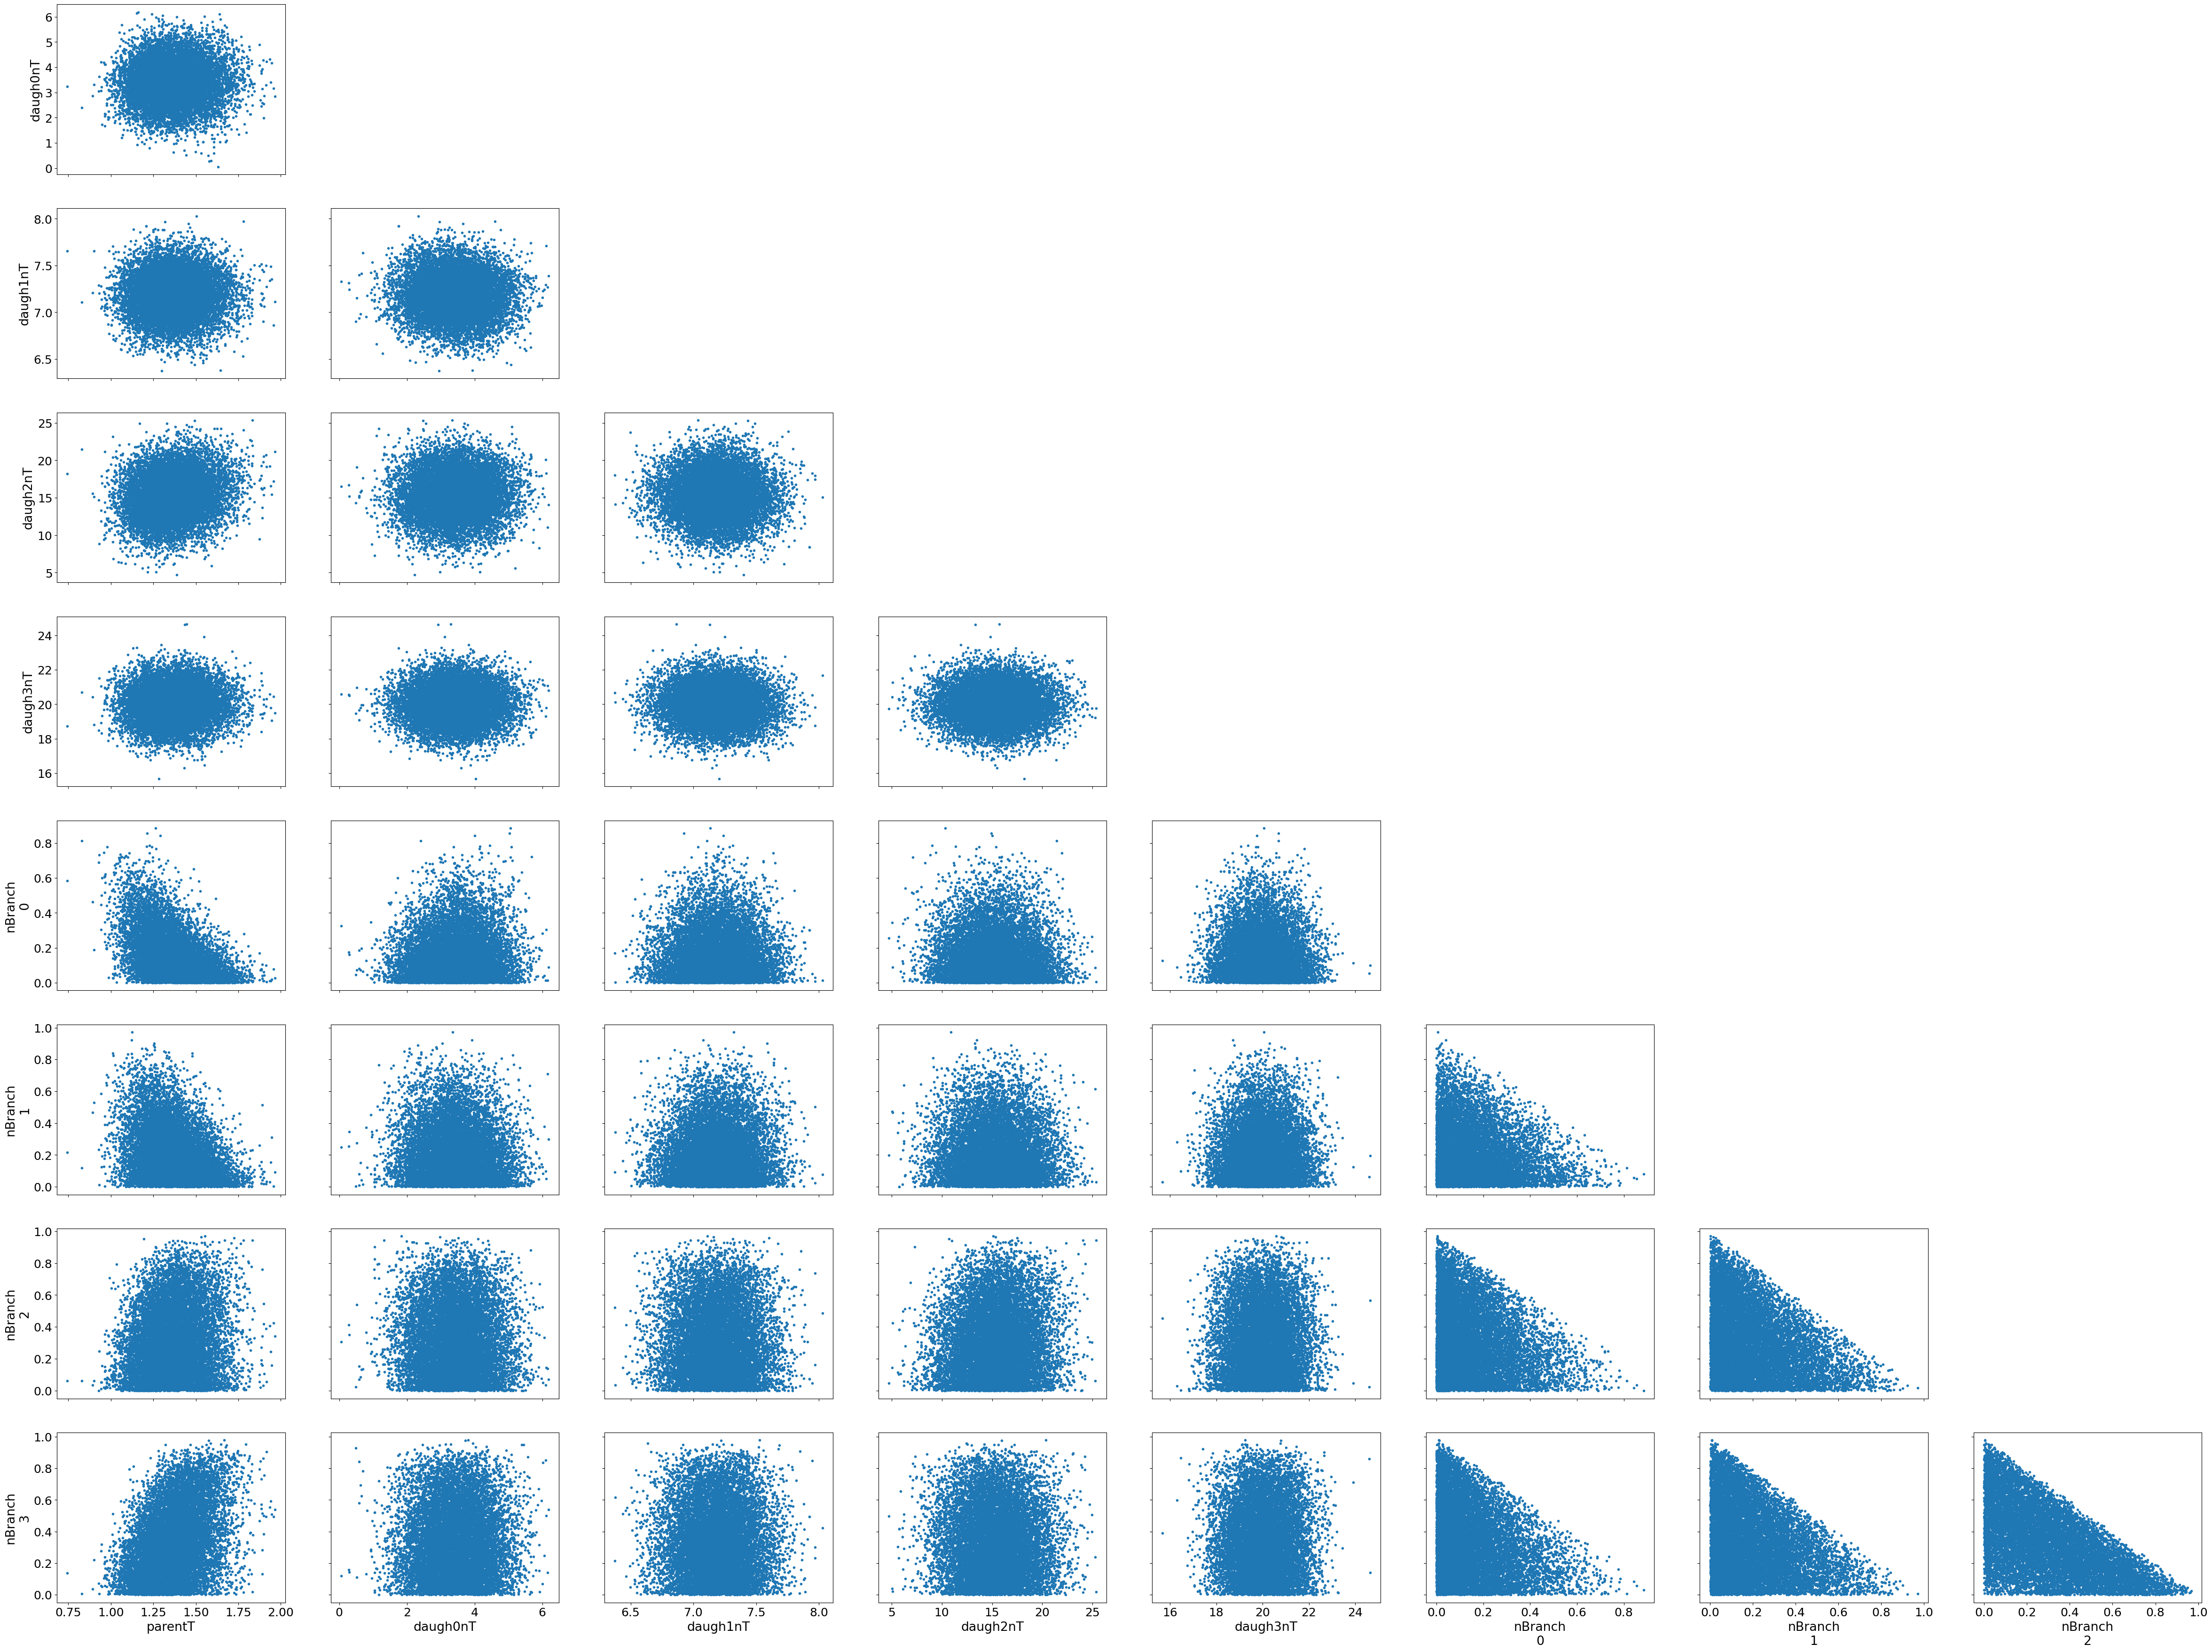

In [87]:
az.plot_pair(trace31F, var_names=['parentT', 'daugh2nT', 'daugh3nT', 'daugh1nT', 'daugh0nT', 'nBranch'],
            filter_vars="regex",
            divergences=False,
            textsize=18)

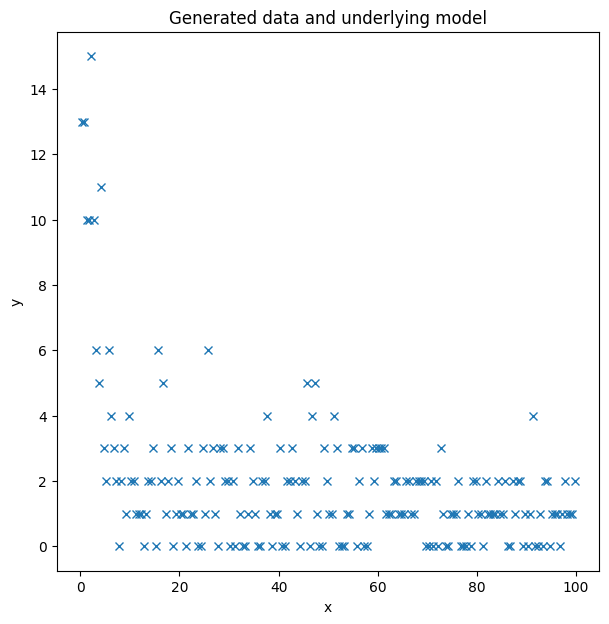

In [89]:
df37Na = pd.read_csv('hist_37Na.csv')
# Filter to only include 0 <= x <= 100
df37Na = df37Na[(df37Na["xVal"] >= 0) & (df37Na["xVal"] <= 100)]

x = df37Na["xVal"]
y = df37Na["yVal"]

fig37Na = plt.figure(figsize=(7, 7))
ax2 = fig37Na.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax2.plot(x, y, "x", label="Data")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, nBranch, backgroundLevel, sigma]


/projects/e21062/tg/venv/lib/python3.7/site-packages/pymc/step_methods/hmc/quadpotential.py:240: RuntimeWarning: overflow encountered in multiply
  return np.multiply(self._var, x, out=out)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 99 seconds.
There were 381 divergences after tuning. Increase `target_accept` or reparameterize.
There were 951 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5954, but should be close to 0.8. Try to increase the number of tuning steps.
There were 977 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6238, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1050 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5447, but should be cl

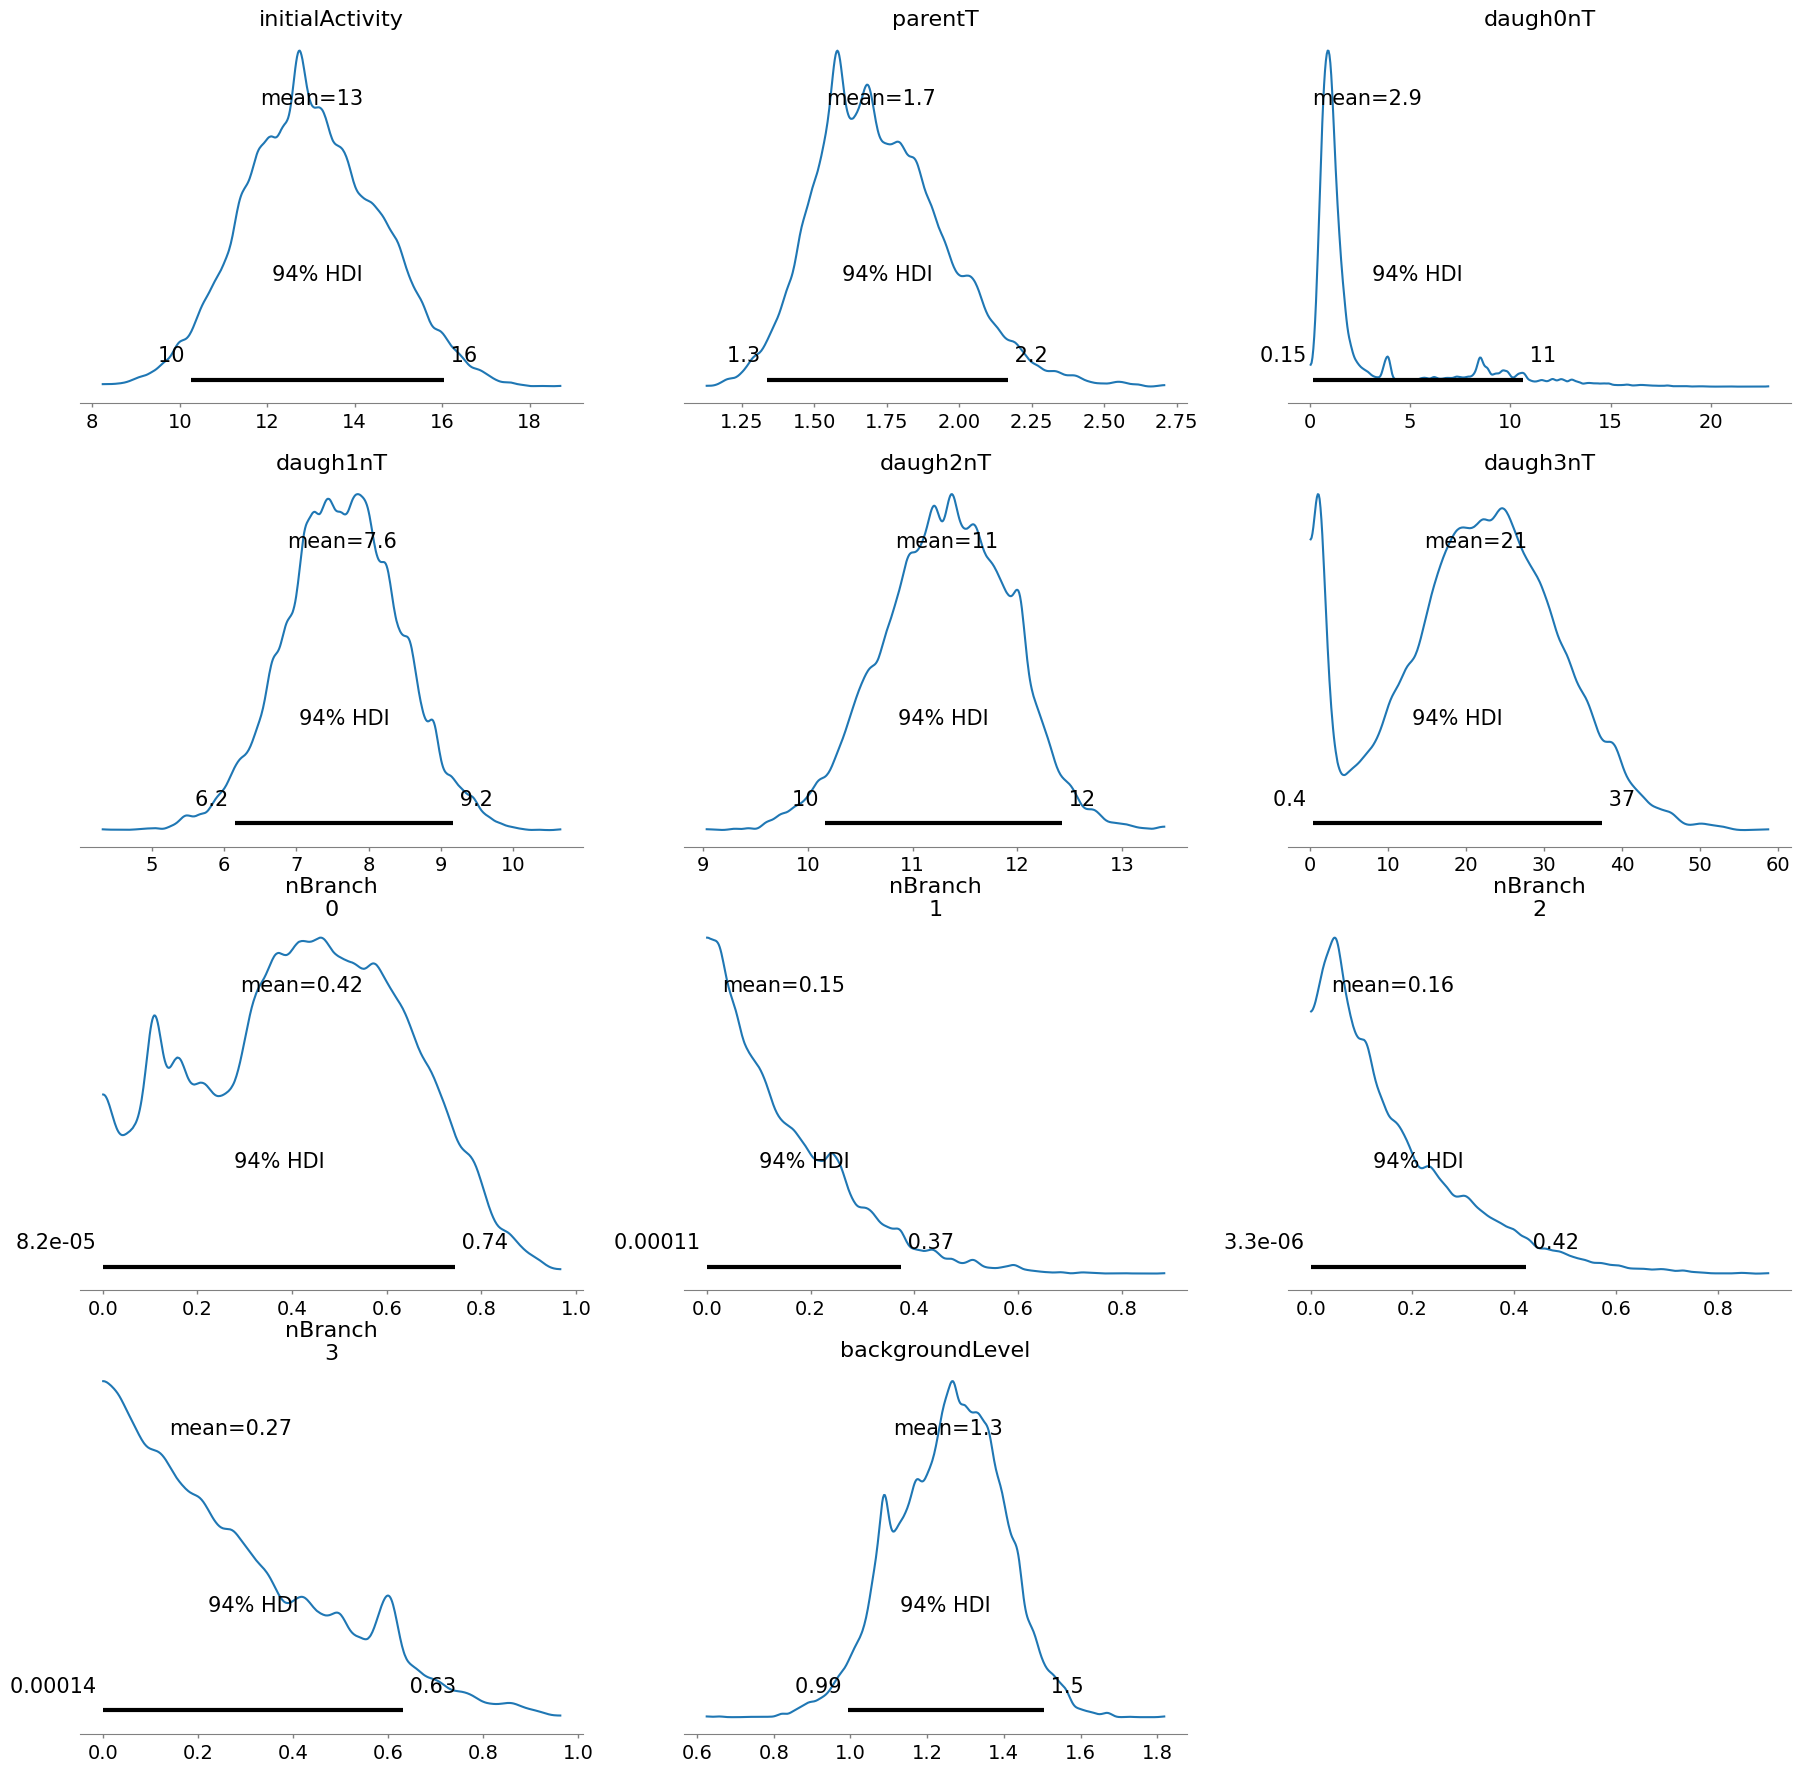

In [90]:
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=15, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=8, sigma=4) # 37Mg T1/2 = 8(4)ms
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.6, sigma=0.8) # 36Mg T1/2 = 7.6+5-8ms
    daughter2nThalf = pm.Normal('daugh2nT', mu=11.3, sigma = 0.6) #35Mg T1/2 = 11.3(6) ms
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma = 10) #34Mg T1/2 = 20(10) ms

    initialActivity = pm.Normal('initialActivity', mu=15, sigma=20)
    #branch0n = pm.Uniform('branch0n', 0., 0.1)
    #branch1n = pm.Uniform('branch1n', 0., (1.-branch0n))
    #branch2n = pm.Uniform('branch2n', 0., (1.-branch0n-branch1n))
    #branch3n = pm.Normal('branch3n', mu=(1.-branch0n-branch1n-branch2n), sigma=0.01)
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of the outcome
    mu = parent3nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, daughter3nThalf, nBranch[0], nBranch[1], nBranch[2], nBranch[3], backgroundLevel, x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs37Na = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    #model.debug()
    
    # Run the MCMC sampling
    trace37Na = pm.sample(3000, tune=1000)

 
# Plot the posterior distributions

pm.plot_posterior(trace37Na, var_names=['initialActivity', 'parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT', 'nBranch', 'backgroundLevel'])
plt.show()

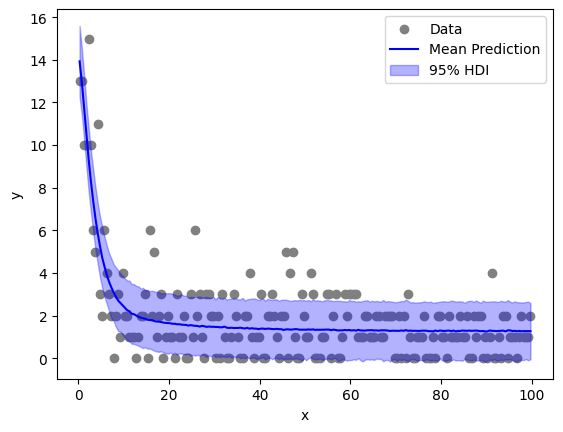

In [91]:
ppc = pm.sample_posterior_predictive(trace37Na, model=model).posterior_predictive
y_pred = np.mean(ppc['y_obs'], axis=0)

y_mean = np.mean(y_pred, axis=0)

y_hdi_lower, y_hdi_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)

# Plot the data points
plt.scatter(x, y, color='grey', label='Data')

# Plot the mean prediction
plt.plot(x, y_mean, color='blue', label='Mean Prediction')

# Plot the HDI intervals as error bars
plt.fill_between(x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

array([[<AxesSubplot:ylabel='daugh0nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh1nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh2nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh3nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubp

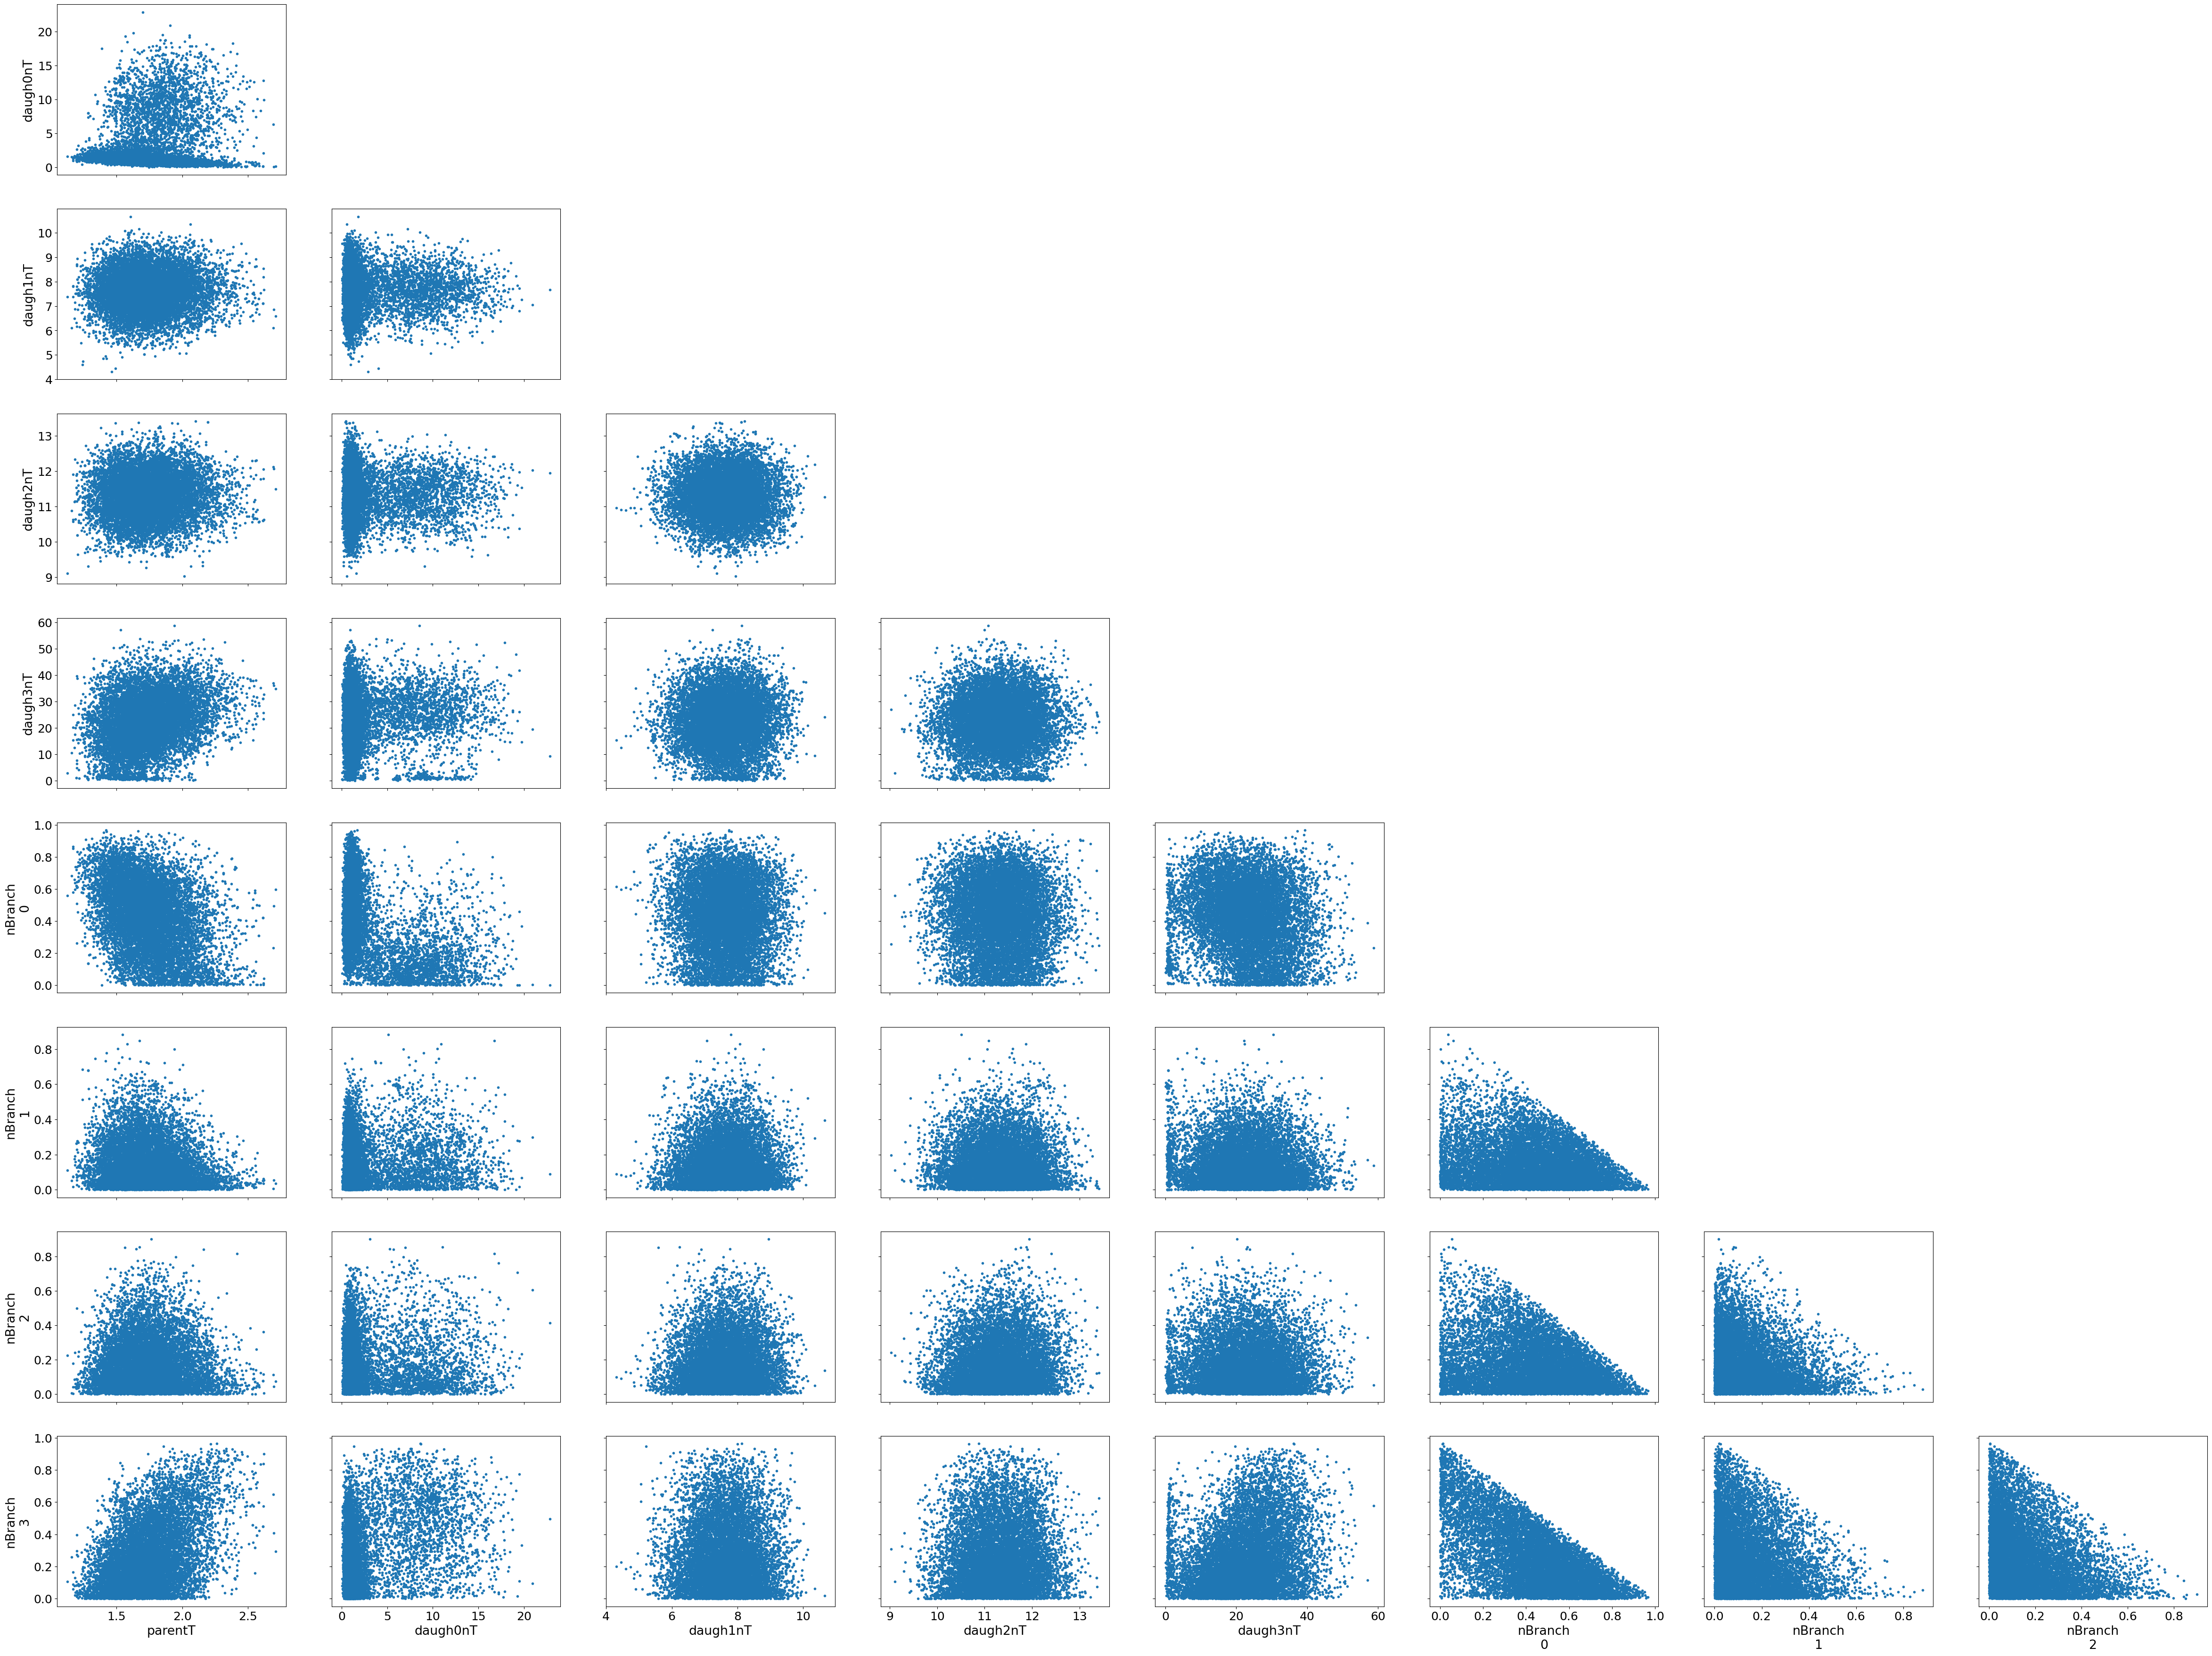

In [92]:
az.plot_pair(trace37Na, var_names=['parentT', 'daugh2nT', 'daugh3nT', 'daugh1nT', 'daugh0nT', 'nBranch'],
            filter_vars="regex",
            divergences=False,
            textsize=18)

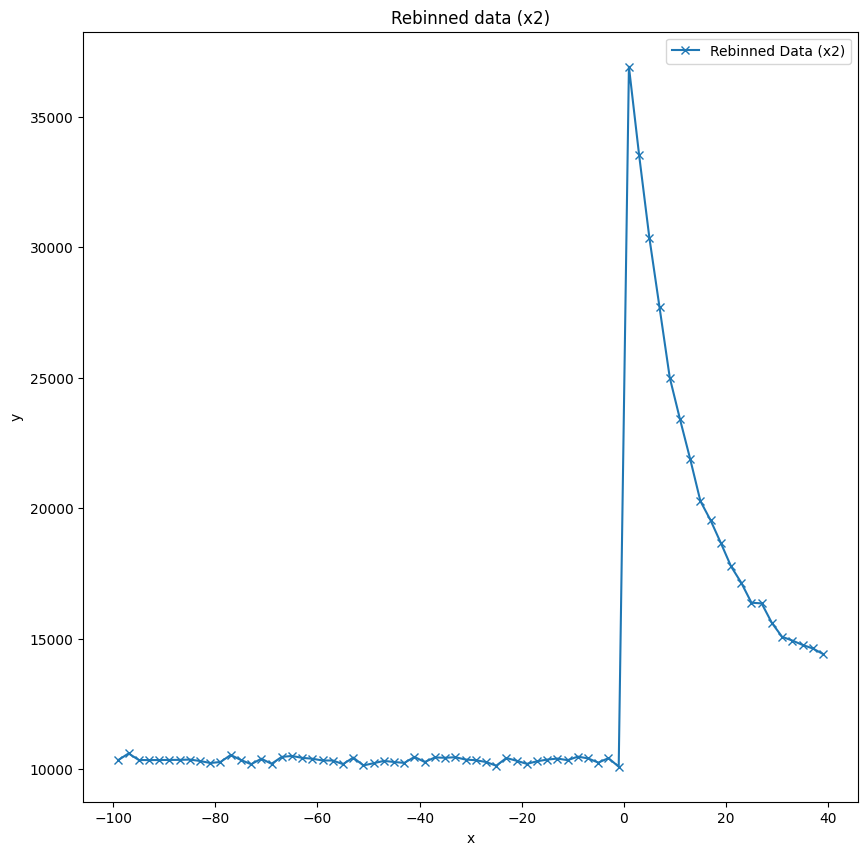

In [196]:
# --- Load and rebin the data ---
df33Na = pd.read_csv('hist_33Na.csv')
df33Na = df33Na[(df33Na["xVal"] >= -100) & (df33Na["xVal"] <=40)]

x = df33Na["xVal"].values
y = df33Na["yVal"].values

# Sort
sorted_idx = np.argsort(x)
x = x[sorted_idx]
y = y[sorted_idx]

# Rebin by 2
if len(x) % 2 != 0:
    x = x[:-1]
    y = y[:-1]

x_rebinned = x.reshape(-1, 4).mean(axis=1)
y_rebinned = y.reshape(-1, 4).sum(axis=1)

# Plot
fig33Na = plt.figure(figsize=(10, 10))
ax2 = fig33Na.add_subplot(111, xlabel="x", ylabel="y", title="Rebinned data (x2)")
ax2.plot(x_rebinned, y_rebinned, "x-", label="Rebinned Data (x2)")
ax2.legend()
plt.show()

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 64 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity_raw, nBranch, backgroundLevel_raw, sigma]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.989, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.988, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9826, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9872, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reac

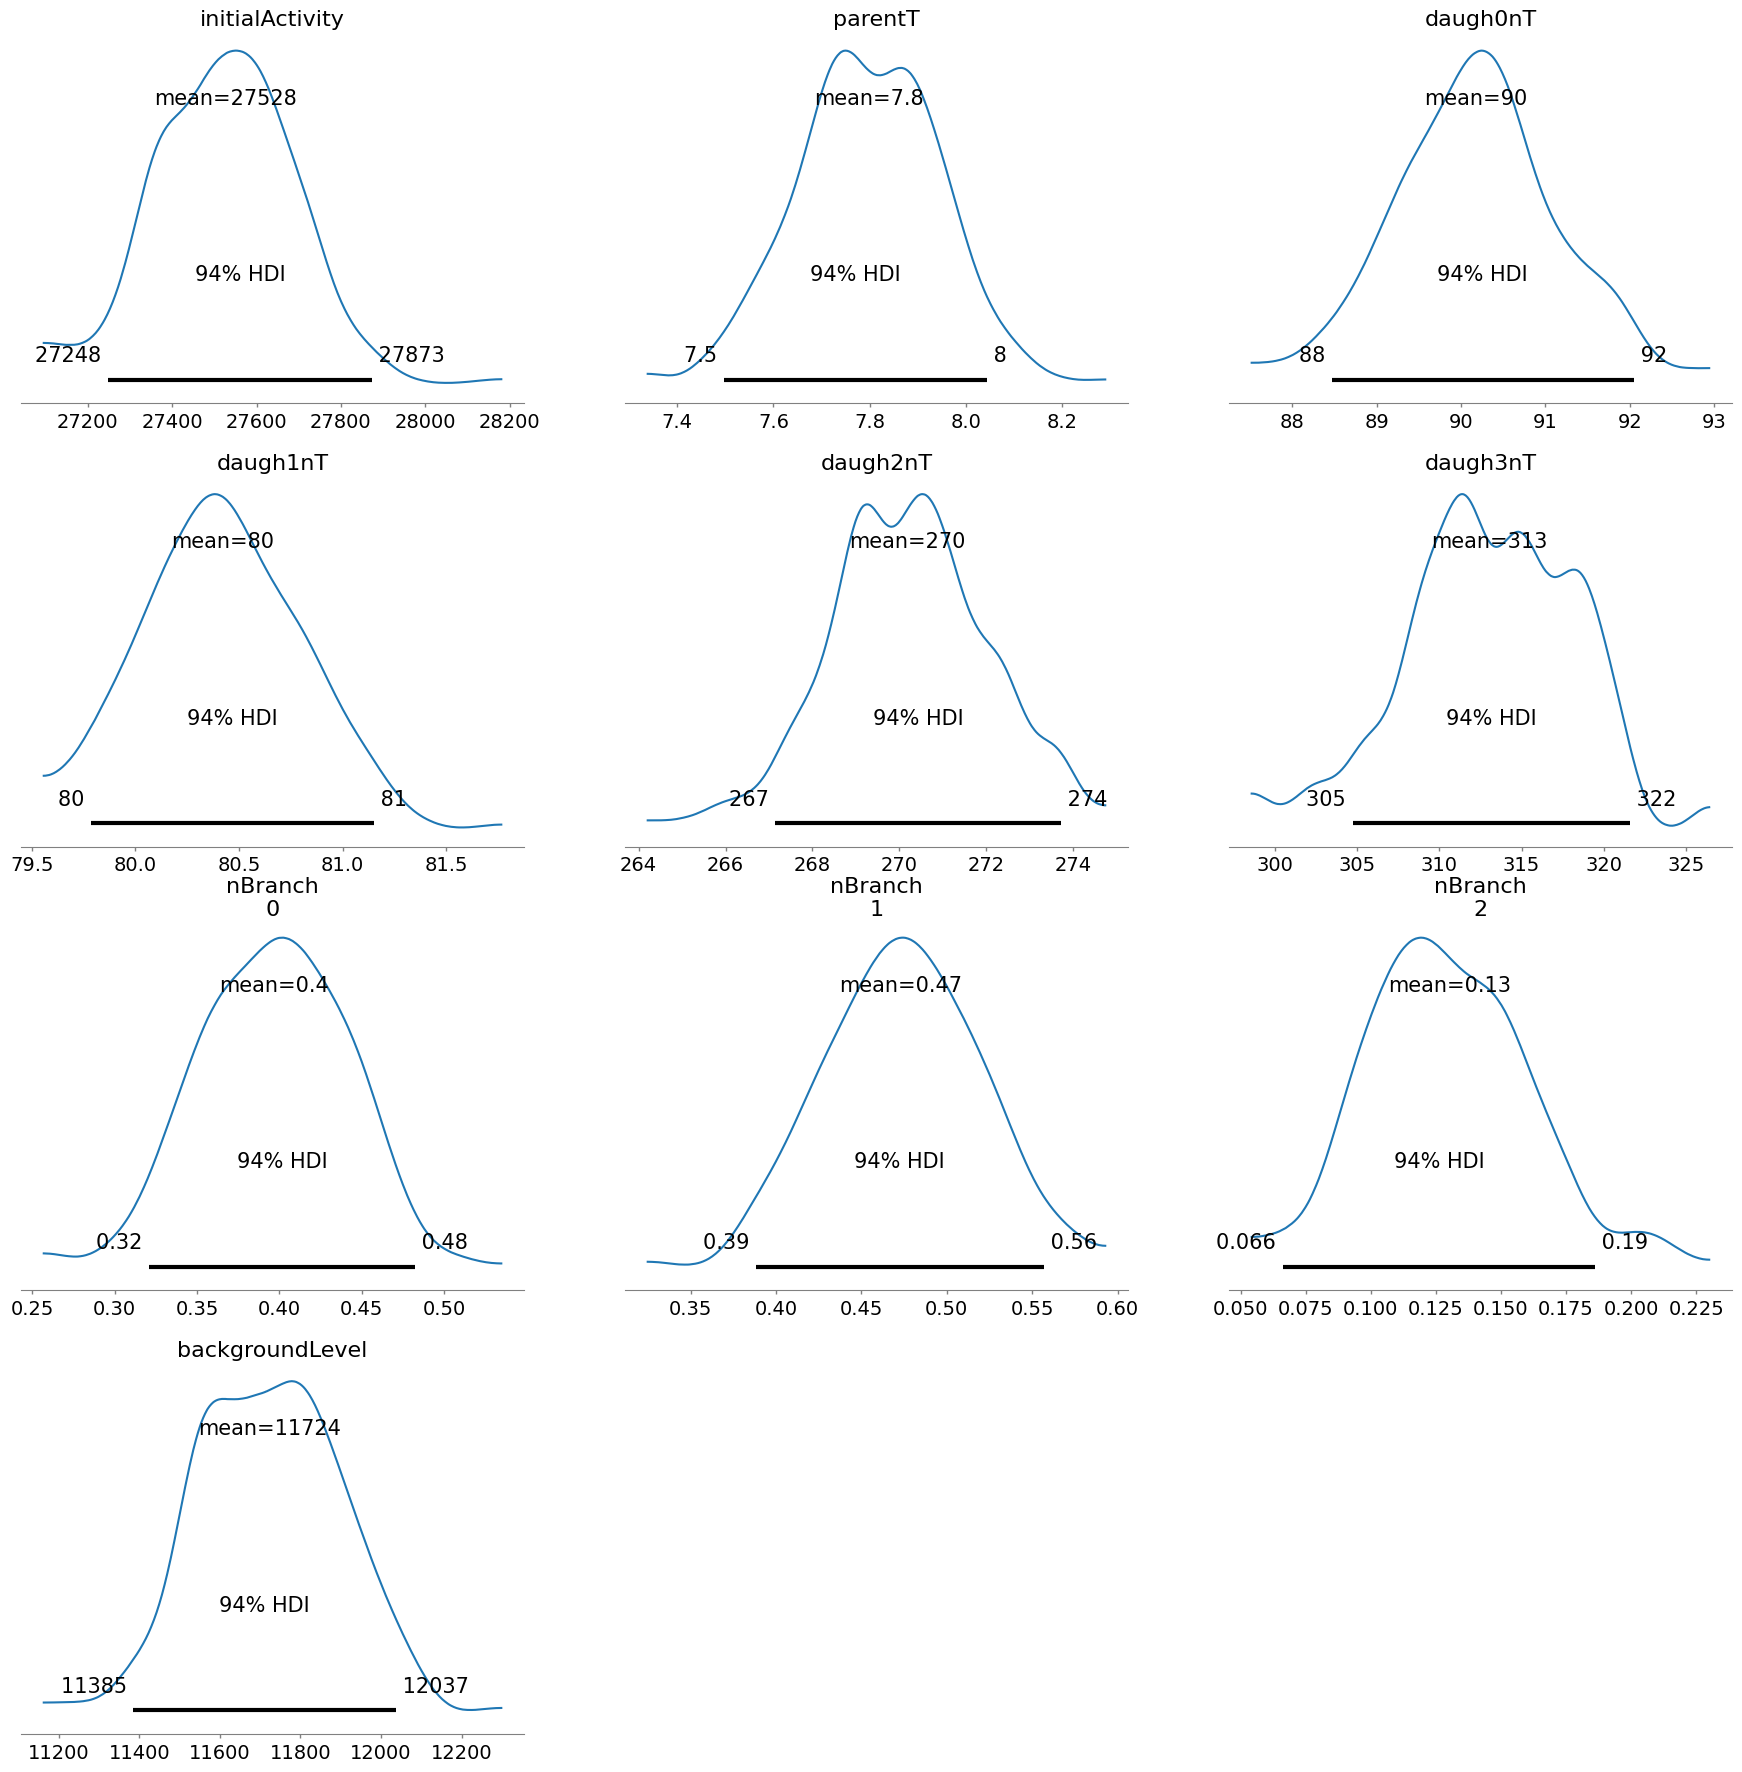

In [ ]:
import multiprocessing
import aesara.tensor as at

decay_x = x_rebinned[x_rebinned >= 0]
decay_y = y_rebinned[x_rebinned >= 0]
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=8.2, sigma=0.2*100)
    daughter0nThalf = pm.Normal('daugh0nT', mu=90.2, sigma=0.9)
    daughter1nThalf = pm.Normal('daugh1nT', mu=80.4, sigma=0.4)
    daughter2nThalf = pm.Normal('daugh2nT', mu=270, sigma=2)
    daughter3nThalf = pm.Normal('daugh3nT', mu=314, sigma=5)
    #initialActivity = pm.Normal('initialActivity', mu=35000, sigma=5000)
    # Prior on a unit interval
    initialActivity_raw = pm.Beta('initialActivity_raw', alpha=2, beta=2)  # mean = 0.5
    initialActivity = pm.Deterministic('initialActivity', 15000 + 25000 * initialActivity_raw)
     # Roughly corresponds to mean ≈ BR, with tunable confidence
    # branch0n = pm.Beta('branch0n', alpha=4, beta=6)      # mean = 0.4
    # branch1n = pm.Beta('branch1n', alpha=47, beta=53)    # mean = 0.47 (tight)
    # branch2n = pm.Beta('branch2n', alpha=13, beta=87)    # mean = 0.13
    # branch3n = pm.Beta('branch3n', alpha=0.1, beta=10)   # close to 0
    """ branch0n = pm.Beta('branch0n', alpha=1, beta=3)
        branch1n = pm.Beta('branch1n', alpha=1, beta=3)
        branch2n = pm.Beta('branch2n', alpha=1, beta=3)
        branch3n = pm.Beta('branch3n', alpha=1, beta=3) """

    """ total_branch = branch0n + branch1n + branch2n + branch3n
        pm.Potential('branching_sum_check', pm.math.switch(total_branch <= 1, 0, -np.inf)) """
    #pm.Potential('branching_soft_penalty', -1e4 * at.maximum(0, total_branch - 1))
    nBranch = pm.Dirichlet('nBranch', a=np.array([4,4.7,1.3])*100)
    #backgroundLevel = pm.Uniform('backgroundLevel', 9000,12000)
    bkg_raw = pm.Beta('backgroundLevel_raw', alpha=2, beta=2)
    backgroundLevel = pm.Deterministic('backgroundLevel', 8000 + (5000 * bkg_raw))
    sigma = pm.HalfNormal('sigma', sigma=500)
    
    # Expected value of the outcome
    #mu = parent3nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, daughter3nThalf, nBranch[0], nBranch[1], nBranch[2], nBranch[3], backgroundLevel, decay_x)
    mu = parent2nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, nBranch[0], nBranch[1], nBranch[2], backgroundLevel, decay_x)
    #sigma = np.sqrt(mu)
    # Likelihood (sampling distribution) of the observations
    y_obs33Na = pm.Normal('y_obs', mu=mu,sigma=sigma, observed=decay_y)
    #model.debug()
    
    # Run the MCMC sampling
    trace33Na = pm.sample(100, tune=100, target_accept=0.999, chains=4, cores=multiprocessing.cpu_count())

 
# Plot the posterior distributions

pm.plot_posterior(trace33Na, var_names=['initialActivity', 'parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT',  'nBranch','backgroundLevel'])
plt.show()

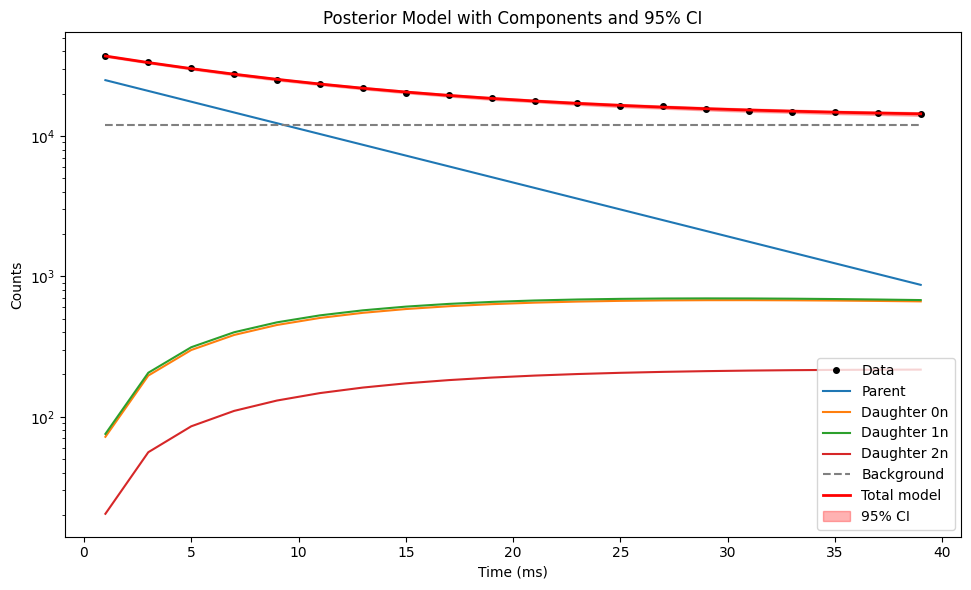

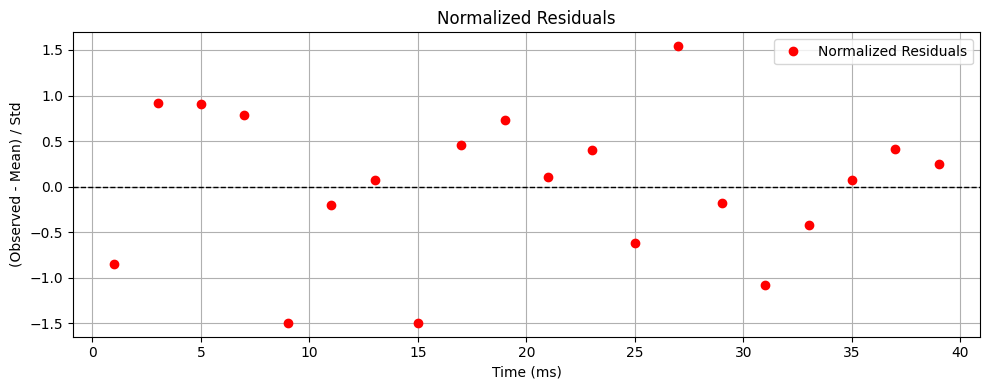

In [223]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Posterior extraction helper
posterior = trace33Na.posterior
mean = lambda name: posterior[name].mean(dim=("chain", "draw")).values

# Posterior means
p_act = mean('initialActivity')
p_hl  = mean('parentT')
d0_hl = mean('daugh0nT')
d1_hl = mean('daugh1nT')
d2_hl = mean('daugh2nT')
br0   = posterior['nBranch'].sel(nBranch_dim_0=0).mean(dim=("chain", "draw")).values
br1   = posterior['nBranch'].sel(nBranch_dim_0=1).mean(dim=("chain", "draw")).values
br2   = posterior['nBranch'].sel(nBranch_dim_0=2).mean(dim=("chain", "draw")).values
bkg   = mean('backgroundLevel')

# Evaluate model using your defined function
parent_y = parent(p_hl, p_act, decay_x)
d0n_y = daughter0n(d0_hl, p_hl, p_act, br0, decay_x)
d1n_y = daughter1n(d1_hl, p_hl, p_act, br1, decay_x)
d2n_y = daughter2n(d2_hl, p_hl, p_act, br2, decay_x)
bkg_y = np.ones_like(decay_x) * bkg
total_y = parent_y + d0n_y + d1n_y + d2n_y + bkg_y

# Posterior predictive samples
ppc = pm.sample_posterior_predictive(trace33Na, model=model, var_names=["y_obs"], progressbar=False)
y_pred_samples = ppc.posterior_predictive['y_obs'].stack(sample=("chain", "draw")).values

# Compute 95% CI
y_lower = np.percentile(y_pred_samples, 2.5, axis=1)
y_upper = np.percentile(y_pred_samples, 97.5, axis=1)

# ---- 📈 Plot Components + CI ----
plt.figure(figsize=(10, 6))
plt.plot(decay_x, decay_y, "ko", label="Data", markersize=4)
plt.plot(decay_x, parent_y, label="Parent")
plt.plot(decay_x, d0n_y, label="Daughter 0n")
plt.plot(decay_x, d1n_y, label="Daughter 1n")
plt.plot(decay_x, d2n_y, label="Daughter 2n")
plt.plot(decay_x, bkg_y, "--", color='gray', label="Background")
plt.plot(decay_x, total_y, "r", lw=2, label="Total model")
plt.fill_between(decay_x, y_lower, y_upper, color='red', alpha=0.3, label="95% CI")

plt.xlabel("Time (ms)")
plt.ylabel("Counts")
plt.title("Posterior Model with Components and 95% CI")
plt.legend()
plt.tight_layout()
plt.yscale("log")
plt.show()

# ---- 📉 Normalized Residuals ----
y_mean = np.mean(y_pred_samples, axis=1)
y_std = np.std(y_pred_samples, axis=1)
residuals = (decay_y - y_mean) / y_std

plt.figure(figsize=(10, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.plot(decay_x, residuals, 'ro', label="Normalized Residuals")
plt.xlabel("Time (ms)")
plt.ylabel("(Observed - Mean) / Std")
plt.title("Normalized Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (280,) and (80,)

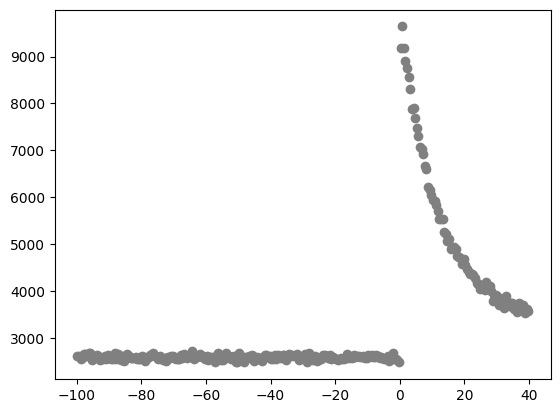

In [20]:
ppc = pm.sample_posterior_predictive(trace33Na, model=model).posterior_predictive
y_pred = np.mean(ppc['y_obs'], axis=0)

y_mean = np.mean(y_pred, axis=0)

y_hdi_lower, y_hdi_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)

# Plot the data points
plt.scatter(x, y, color='grey', label='Data')

# Plot the mean prediction
plt.plot(x, y_mean, color='blue', label='Mean Prediction')

# Plot the HDI intervals as error bars
plt.fill_between(x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()